# Lab: Understanding Multi-View Variational Autoencoders (MVAE)


## PARTICIPANTS:

### __OSCAR MONTOYA AMORES (100451858), MIGUEL ANGEL PONCE MARTINEZ (100451309)__

## Libraries

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets
from torch.utils.data import ConcatDataset, DataLoader
import torchvision.transforms as transforms
from torch import optim
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**WORKING IN COLAB:**

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  path_to_folder = '/content/drive/My Drive/NeuralNetworks/MVAE/'

except ImportError:
  path_to_folder = './data/'


Mounted at /content/drive


## Part I: Loading MNIST and SVHM dataset

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, data,labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, target = self.data[idx], int(self.labels[idx])

        # print(img.shape)

        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, target

class CombinedDataset(Dataset):
    def __init__(self, mnist_data,svhm_data, mnist_labels, svhm_labels, mnist_transform=None, svhm_transform = None):
        self.mnist_data = mnist_data
        self.svhm_data = svhm_data
        self.mnist_labels = mnist_labels
        self.svhm_labels = svhm_labels
        self.mnist_transform = mnist_transform
        self.svhm_transform = svhm_transform

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        mnist_img, svhm_img, mnist_target, svhm_target = self.mnist_data[idx], self.svhm_data[idx], int(self.mnist_labels[idx]), int(self.svhm_labels[idx])

        # Apply transformations if provided
        if self.mnist_transform:
            mnist_img = self.mnist_transform(mnist_img)

        if self.svhm_transform:
          svhm_img = self.svhm_transform(svhm_img)


        return mnist_img, svhm_img, mnist_target, svhm_target


In [ ]:
def get_dataset(batch_size,  dataset_directory = './data'):

    mnist_transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),
        #transforms.Normalize((0), (1)),
    ])

    svhm_transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64),antialias=True ),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        #transforms.Normalize((0, 0, 0), (1, 1, 1)),
    ])

    svhm_transformation_gray = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64),antialias=True ),
        transforms.Normalize((0.5), (0.5))
    ])

    #MNIST:
    mnist_train_dataset = torchvision.datasets.MNIST(dataset_directory, download = True, transform = mnist_transformation)

    # Use sampler for randomization
    training_sampler = torch.utils.data.SubsetRandomSampler(range(len(mnist_train_dataset)))

    # Prepare Data Loaders for training and validation
    mnist_trainloader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=batch_size, sampler=training_sampler)

    #SVHN:

    svhm_train_dataset = torchvision.datasets.SVHN(dataset_directory, download = True, transform = svhm_transformation)

    # Use sampler for randomization
    training_sampler = torch.utils.data.SubsetRandomSampler(range(len(svhm_train_dataset)))

    # Prepare Data Loaders for training and validation
    svhm_trainloader = torch.utils.data.DataLoader(svhm_train_dataset, batch_size=batch_size, sampler=training_sampler)

    #Combined Train

    # #Transform into Numpy Arrays
    mnist_data  = mnist_train_dataset.data.numpy()
    mnist_label  = mnist_train_dataset.targets.numpy()

    svhm_data  = svhm_train_dataset.data.transpose(0,2,3,1)
    svhm_label  = svhm_train_dataset.labels

    # #Find labels ammount per number
    mnist_values = np.zeros((10))
    svhm_values = np.zeros((10))
    for n in range(10):
        mnist_values[n] = np.sum(mnist_label == n)
        svhm_values[n] = np.sum(svhm_label == n)

    # mnist_values: [5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
    # svhm_values: [ 4948. 13861. 10585.  8497.  7458.  6882.  5727.  5595.  5045.  4659.]

    #4000 elements per number will be selected an ordered
    elements_to_train = 4000
    elements_to_val = 600
    elements_to_represent = 4
    x = elements_to_train*10

    y,z = mnist_data.shape[1], mnist_data.shape[2]
    mnist_dataset_sorted = np.zeros((x,y,z),dtype= np.uint8)
    mnist_val = np.zeros((elements_to_val*10,y,z),dtype= np.uint8)
    mnist_reconstruct = np.zeros((elements_to_represent*10,y,z),dtype= np.uint8)

    #ORIGINAL
    c,y,z = svhm_data.shape[1], svhm_data.shape[2], svhm_data.shape[3]
    svhm_dataset_sorted = np.zeros((x,c,y,z), dtype= np.uint8)
    svhm_val = np.zeros((elements_to_val*10,c,y,z), dtype= np.uint8)
    svhm_reconstruct = np.zeros((elements_to_represent*10,c,y,z), dtype= np.uint8)

    # gray_svhm_data = np.dot(svhm_data[..., :3], [0.2989, 0.5870, 0.1140])

    # y,z = svhm_data.shape[1], svhm_data.shape[2]
    # svhm_dataset_sorted = np.zeros((x,y,z), dtype= np.uint8)

    labels_sorted = np.zeros((x))
    val_label = np.zeros((elements_to_val*10))
    reconstruct_label = np.zeros((elements_to_represent*10))

    for n in range(10):
        mnist_indeces = np.where(mnist_label == n)[0][:elements_to_train] #First 4000 elements
        mnist_dataset_sorted[n*elements_to_train:(n+1)*elements_to_train,:,:] = mnist_data[mnist_indeces,:,:]

        #ORIGINAL
        svhm_indeces = np.where(svhm_label == n)[0][:elements_to_train] #First 4000 elements
        svhm_dataset_sorted[n*elements_to_train:(n+1)*elements_to_train,:,:,:] = svhm_data[svhm_indeces,:,:,:]

        labels_sorted[n*elements_to_train:(n+1)*elements_to_train] = n

        #VALIDATION DATASET
        mnist_indeces = np.random.choice(np.where(mnist_label == n)[0][elements_to_train:], elements_to_val, replace=False)
        mnist_val[n*elements_to_val:(n+1)*elements_to_val,:,:] = mnist_data[mnist_indeces,:,:]

        svhm_indeces = np.random.choice(np.where(svhm_label == n)[0][elements_to_train:], elements_to_val, replace=False)
        svhm_val[n*elements_to_val:(n+1)*elements_to_val,:,:,:] = svhm_data[svhm_indeces,:,:,:]

        val_label[n*elements_to_val:(n+1)*elements_to_val] = n

        #RECONSTRUCTION DATASETS
        mnist_rec_idx = np.random.choice(np.where(mnist_label == n)[0][elements_to_train:], elements_to_represent, replace=False)
        svhm_rec_idx = np.random.choice(np.where(svhm_label == n)[0][elements_to_train:], elements_to_represent, replace=False)

        mnist_reconstruct[n*elements_to_represent:(n+1)*elements_to_represent,:,:] = mnist_data[mnist_rec_idx,:,:]
        svhm_reconstruct[n*elements_to_represent:(n+1)*elements_to_represent,:,:,:] = svhm_data[svhm_rec_idx,:,:,:]

        reconstruct_label[n*elements_to_represent:(n+1)*elements_to_represent] = n

        # svhm_indeces = np.where(svhm_label == n)[0][:4000] #First 4000 elements
        # svhm_dataset_sorted[n*4000:(n+1)*4000,:,:] = gray_svhm_data[svhm_indeces,:,:]


    #NEW TRAINLOADER: EACH IMAGE ASSOCIATED TO 20 IMAGES BY LABEL
    #(400 instances per number associated to 20 from the other dataset)
    #And repeat the same for other 400 instances per number in the other dataset. In total, 400*10*20*2 = 160000 images to iterate

    #1. Define Variables:
    elements_to_train = 400
    elements_to_val = 100
    elements_to_pair = 20

    #MNIST
    y,z = mnist_data.shape[1], mnist_data.shape[2]
    mnist_final_dataset = np.zeros((elements_to_train*10*elements_to_pair,y,z),dtype= np.uint8)
    mnist_final_val = np.zeros((elements_to_val*10*elements_to_pair,y,z),dtype= np.uint8)
    #Random Variables (Will include all the values which are paired with the repeated instances)
    mnist_random_dataset = np.zeros((elements_to_train*10*elements_to_pair,y,z),dtype= np.uint8)
    mnist_random_val = np.zeros((elements_to_val*10*elements_to_pair,y,z),dtype= np.uint8)

    #SVHN
    c,y,z = svhm_data.shape[1], svhm_data.shape[2], svhm_data.shape[3]
    svhm_final_dataset= np.zeros((elements_to_train*10*elements_to_pair,c,y,z), dtype= np.uint8)
    svhm_final_val = np.zeros((elements_to_val*10*elements_to_pair,c,y,z), dtype= np.uint8)
    #Random Variables (Will include all the values which are paired with the repeated instances)
    svhm_random_dataset= np.zeros((elements_to_train*10*elements_to_pair,c,y,z), dtype= np.uint8)
    svhm_random_val = np.zeros((elements_to_val*10*elements_to_pair,c,y,z), dtype= np.uint8)

    #LABEL
    labels_final = np.zeros((elements_to_train*10*elements_to_pair))
    val_label_final = np.zeros((elements_to_val*10*elements_to_pair))

    #2. Retrieve Data Indices
    for n in range(10):
      #MNIST
      mnist_all_indices = np.where(mnist_label == n)[0]
      np.random.shuffle(mnist_all_indices)
      mnist_train_idx = mnist_all_indices[:elements_to_train]
      mnist_val_idx = mnist_all_indices[elements_to_train:elements_to_val+elements_to_train]

      #SVHN
      svhm_all_indices = np.where(svhm_label == n)[0]
      np.random.shuffle(svhm_all_indices)
      svhm_train_idx = svhm_all_indices[:elements_to_train]
      svhm_val_idx = svhm_all_indices[elements_to_train:elements_to_val+elements_to_train]

      #NEW RECONSTRUCT
      mnist_rec_idx = np.random.choice(mnist_all_indices[:elements_to_train], elements_to_represent, replace=False)
      svhm_rec_idx = np.random.choice(svhm_all_indices[:elements_to_train], elements_to_represent, replace=False)

      mnist_reconstruct[n*elements_to_represent:(n+1)*elements_to_represent,:,:] = mnist_data[mnist_rec_idx,:,:]
      svhm_reconstruct[n*elements_to_represent:(n+1)*elements_to_represent,:,:,:] = svhm_data[svhm_rec_idx,:,:,:]

      reconstruct_label[n*elements_to_represent:(n+1)*elements_to_represent] = n

    #3. Generate final dataset
      #MNIST TRAIN PAIRING
      for i,v in enumerate(mnist_train_idx):
        mnist_final_dataset[n*elements_to_train*elements_to_pair + i*elements_to_pair:n*elements_to_train*elements_to_pair + (i+1)*elements_to_pair,:,:] = mnist_data[v,:,:]
        random_indices = np.random.choice(svhm_all_indices[elements_to_val+elements_to_train:], elements_to_pair, replace=False)
        svhm_random_dataset[n*elements_to_train*elements_to_pair + i*elements_to_pair:n*elements_to_train*elements_to_pair + (i+1)*elements_to_pair,:,:,:] = svhm_data[random_indices,:,:,:]

      #MNIST VAL PAIRING
      for i,v in enumerate(mnist_val_idx):
        mnist_final_val[n*elements_to_val*elements_to_pair + i*elements_to_pair:n*elements_to_val*elements_to_pair + (i+1)*elements_to_pair,:,:] = mnist_data[v,:,:]
        random_indices = np.random.choice(svhm_all_indices[elements_to_val+elements_to_train:], elements_to_pair, replace=False)
        svhm_random_val[n*elements_to_val*elements_to_pair + i*elements_to_pair:n*elements_to_val*elements_to_pair + (i+1)*elements_to_pair,:,:,:] = svhm_data[random_indices,:,:,:]

      #SVHN PAIRING
      for i,v in enumerate(svhm_train_idx):
        svhm_final_dataset[n*elements_to_train*elements_to_pair + i*elements_to_pair:n*elements_to_train*elements_to_pair + (i+1)*elements_to_pair,:,:] = svhm_data[v,:,:]
        random_indices = np.random.choice(mnist_all_indices[elements_to_val+elements_to_train:], elements_to_pair, replace=False)
        mnist_random_dataset[n*elements_to_train*elements_to_pair + i*elements_to_pair:n*elements_to_train*elements_to_pair + (i+1)*elements_to_pair,:,:] = mnist_data[random_indices,:,:]

      #SVHN VAL PAIRING
      for i,v in enumerate(svhm_val_idx):
        svhm_final_val[n*elements_to_val*elements_to_pair + i*elements_to_pair:n*elements_to_val*elements_to_pair + (i+1)*elements_to_pair,:,:] = svhm_data[v,:,:]
        random_indices = np.random.choice(mnist_all_indices[elements_to_val+elements_to_train:], elements_to_pair, replace=False)
        mnist_random_val[n*elements_to_val*elements_to_pair + i*elements_to_pair:n*elements_to_val*elements_to_pair + (i+1)*elements_to_pair,:,:] = mnist_data[random_indices,:,:]

      labels_final[n*elements_to_train*elements_to_pair:(n+1)*elements_to_train*elements_to_pair] = n
      val_label_final[n*elements_to_val*elements_to_pair:(n+1)*elements_to_val*elements_to_pair] = n


    #4. Join datasets in an unique variable
    mnist_final_dataset = np.concatenate((mnist_final_dataset, mnist_random_dataset),axis=0)
    mnist_final_val = np.concatenate((mnist_final_val, mnist_random_val),axis=0)
    svhm_final_dataset = np.concatenate((svhm_random_dataset, svhm_final_dataset),axis=0)
    svhm_final_val = np.concatenate((svhm_random_val, svhm_final_val),axis=0)
    labels_final = np.concatenate((labels_final, labels_final),axis=0)
    val_label_final = np.concatenate((val_label_final, val_label_final),axis=0)



    #COMBINED DATALOADER FOR MULTI-VIEW VAEs
    trainloader_sorted = CombinedDataset(mnist_data=mnist_dataset_sorted, svhm_data=svhm_dataset_sorted, mnist_labels=labels_sorted, svhm_labels=labels_sorted, mnist_transform=mnist_transformation, svhm_transform=svhm_transformation)
    training_sampler = torch.utils.data.SubsetRandomSampler(range(len(mnist_dataset_sorted)))
    trainloader_sorted =  torch.utils.data.DataLoader(trainloader_sorted, batch_size=batch_size, sampler = training_sampler)

    #COMBINED VALIDLOADER FOR MULTI-VIEW VAEs
    validloader_sorted = CombinedDataset(mnist_data=mnist_val, svhm_data=svhm_val, mnist_labels=val_label, svhm_labels=val_label, mnist_transform=mnist_transformation, svhm_transform=svhm_transformation)
    validation_sampler = torch.utils.data.SubsetRandomSampler(range(len(mnist_val)))
    validloader_sorted =  torch.utils.data.DataLoader(validloader_sorted, batch_size=batch_size, sampler = validation_sampler)

    #UNIQUE BATCH INCLUDING ALL NUMBERS FOR RECONSTRUCTION
    #MNIST:
    mnist_reconstruct_trainloader =  CustomDataset(mnist_reconstruct.astype('uint8'),reconstruct_label, transform = mnist_transformation)
    mnist_reconstruct_trainloader = torch.utils.data.DataLoader(mnist_reconstruct_trainloader, batch_size=40)
    #SVHM:
    svhm_reconstruct_trainloader =  CustomDataset(svhm_reconstruct.astype('uint8'),reconstruct_label, transform = svhm_transformation)
    svhm_reconstruct_trainloader = torch.utils.data.DataLoader(svhm_reconstruct_trainloader, batch_size=40)

    #FINAL DATASET (EACH IMAGE FROM EACH DATASET PAIRED WITH OTHER 20 IMAGES FROM THE OTHER DATASET)
    #TRAINLOADER
    trainloader_final = CombinedDataset(mnist_data=mnist_final_dataset, svhm_data=svhm_final_dataset, mnist_labels=labels_final, svhm_labels=labels_final, mnist_transform=mnist_transformation, svhm_transform=svhm_transformation)
    training_sampler = torch.utils.data.SubsetRandomSampler(range(len(mnist_final_dataset)))
    trainloader_final =  torch.utils.data.DataLoader(trainloader_final, batch_size=batch_size, sampler = training_sampler)
    #VALIDLOADER
    validloader_final = CombinedDataset(mnist_data=mnist_final_val, svhm_data=svhm_final_val, mnist_labels=val_label_final, svhm_labels=val_label_final, mnist_transform=mnist_transformation, svhm_transform=svhm_transformation)
    validation_sampler = torch.utils.data.SubsetRandomSampler(range(len(mnist_final_val)))
    validloader_final =  torch.utils.data.DataLoader(validloader_final, batch_size=batch_size, sampler = validation_sampler)

    #SVHM_GRAY TRAINLOADER
    # svhm_gray_trainloader = CustomDataset(gray_svhm_data.astype('uint8'),svhm_label, transform = svhm_transformation_gray)
    # training_sampler = torch.utils.data.SubsetRandomSampler(range(len(svhm_gray_trainloader)))
    # svhm_gray_trainloader = torch.utils.data.DataLoader(svhm_gray_trainloader, batch_size=batch_size, sampler=training_sampler)

    # trainloader_sorted = CombinedDataset(mnist_data=mnist_dataset_sorted, svhm_data=svhm_dataset_sorted, mnist_labels=labels_sorted, svhm_labels=labels_sorted, mnist_transform=mnist_transformation, svhm_transform=svhm_transformation_gray)
    # training_sampler = torch.utils.data.SubsetRandomSampler(range(len(mnist_dataset_sorted)))
    # trainloader_sorted =  torch.utils.data.DataLoader(trainloader_sorted, batch_size=batch_size, sampler = training_sampler)


    # svhm_gray_trainloader = CustomDataset(gray_svhm_data.astype('uint8'),svhm_label, transform = svhm_transformation_gray)
    # training_sampler = torch.utils.data.SubsetRandomSampler(range(len(svhm_gray_trainloader)))
    # svhm_gray_trainloader = torch.utils.data.DataLoader(svhm_gray_trainloader, batch_size=batch_size, sampler=training_sampler)

    plt.imshow(mnist_data[0], cmap='gray')
    plt.show()
    plt.imshow(svhm_data[0])
    plt.show()
    plt.imshow(svhm_final_dataset[0])
    plt.show()
    # plt.imshow(gray_svhm_data[0], cmap='gray')
    # plt.show()

    return mnist_trainloader, svhm_trainloader, trainloader_sorted, validloader_sorted, mnist_reconstruct_trainloader, svhm_reconstruct_trainloader, trainloader_final, validloader_final

Using downloaded and verified file: /content/drive/My Drive/NeuralNetworks/MVAE/train_32x32.mat


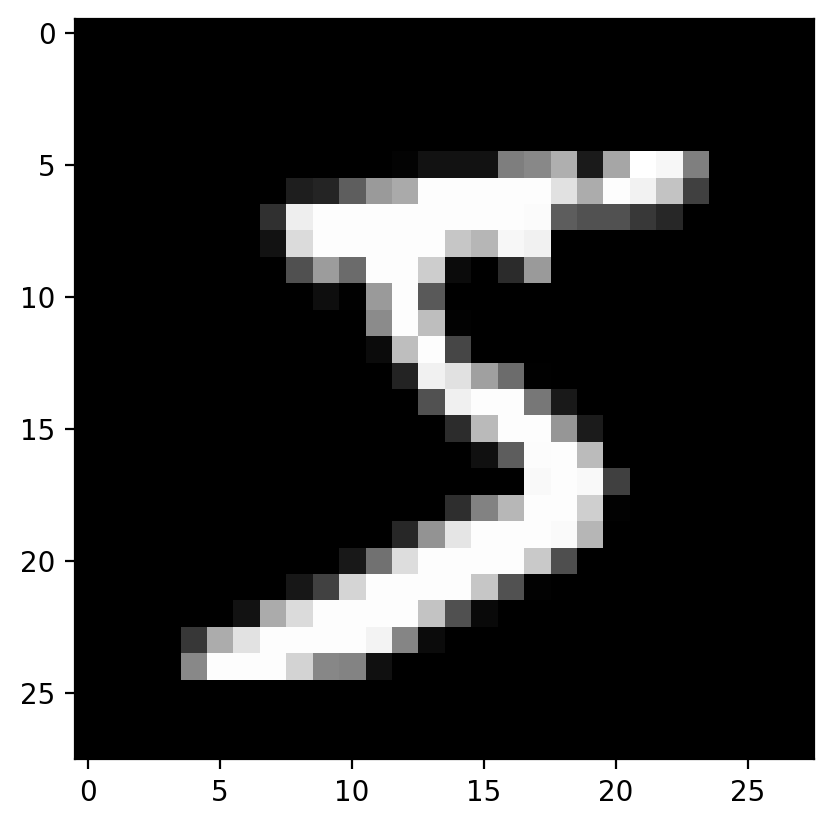

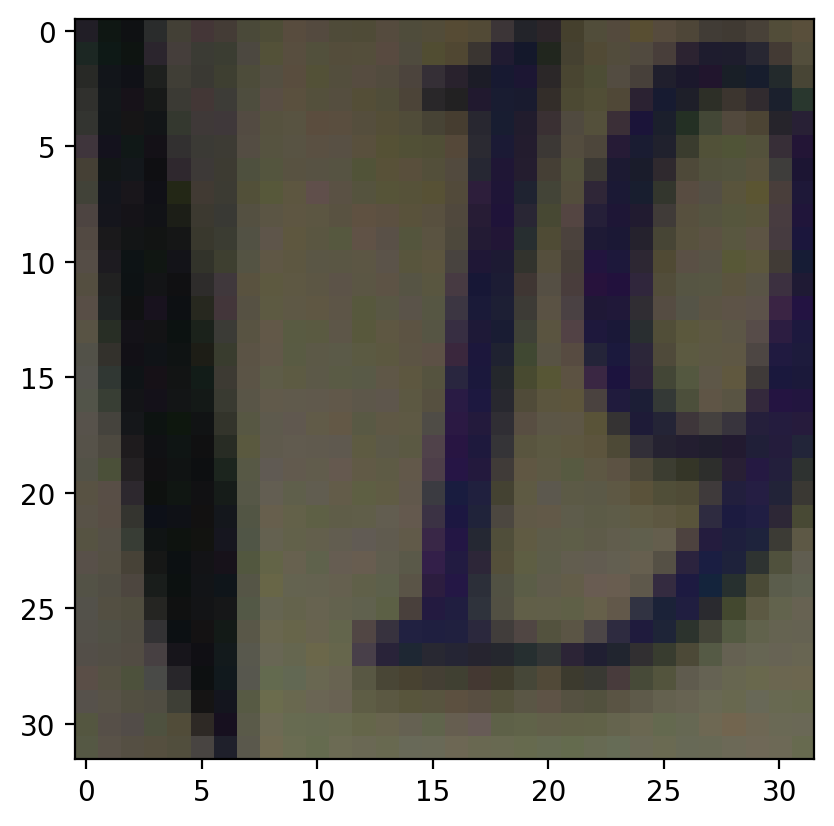

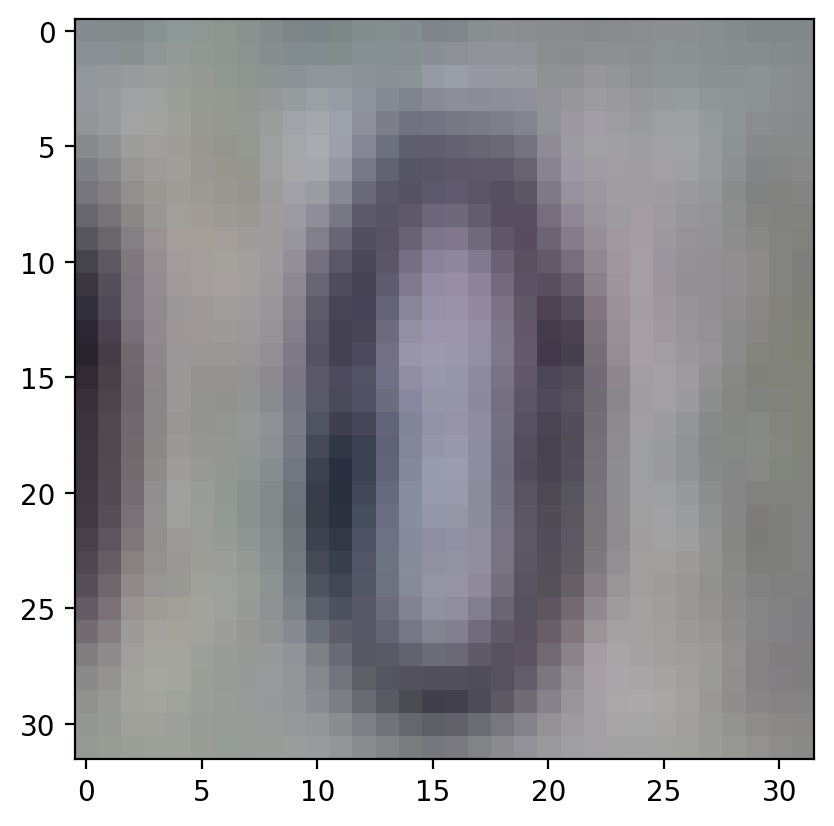

In [ ]:
mnist_trainloader, svhm_trainloader, trainloader_sorted, validloader_sorted, mnist_reconstruct_trainloader, svhm_reconstruct_trainloader, trainloader_final, validloader_final = get_dataset(32,path_to_folder)

## Part II: Visualization of MNIST and SVHM dataset

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

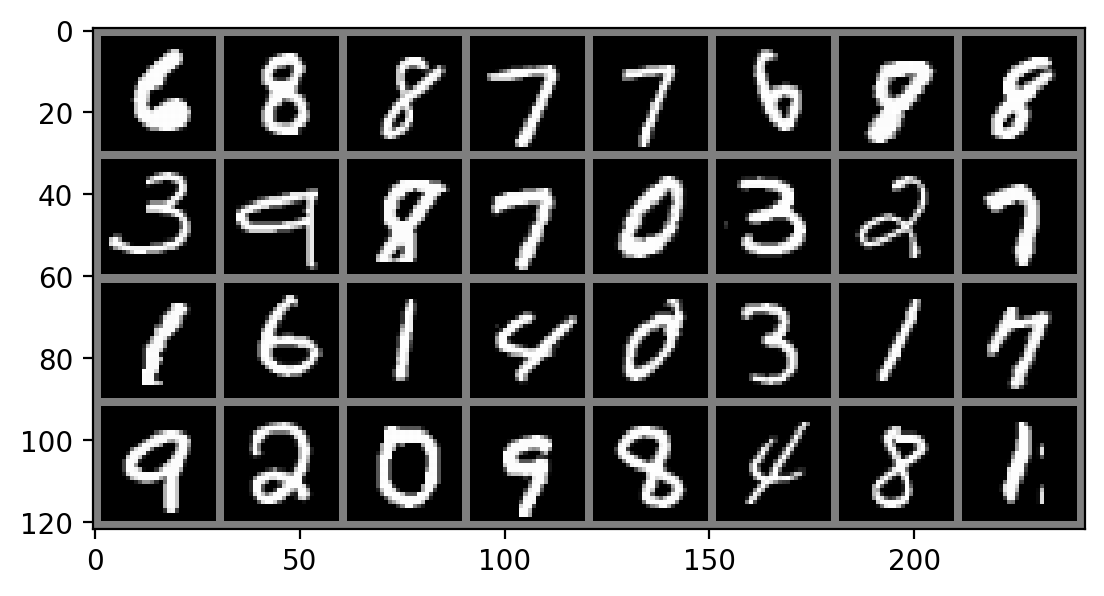

tensor([6, 8, 8, 7, 7, 6, 8, 8, 3, 9, 8, 7, 0, 3, 2, 7, 1, 6, 1, 4, 0, 3, 1, 7,
        9, 2, 0, 9, 8, 4, 8, 1])


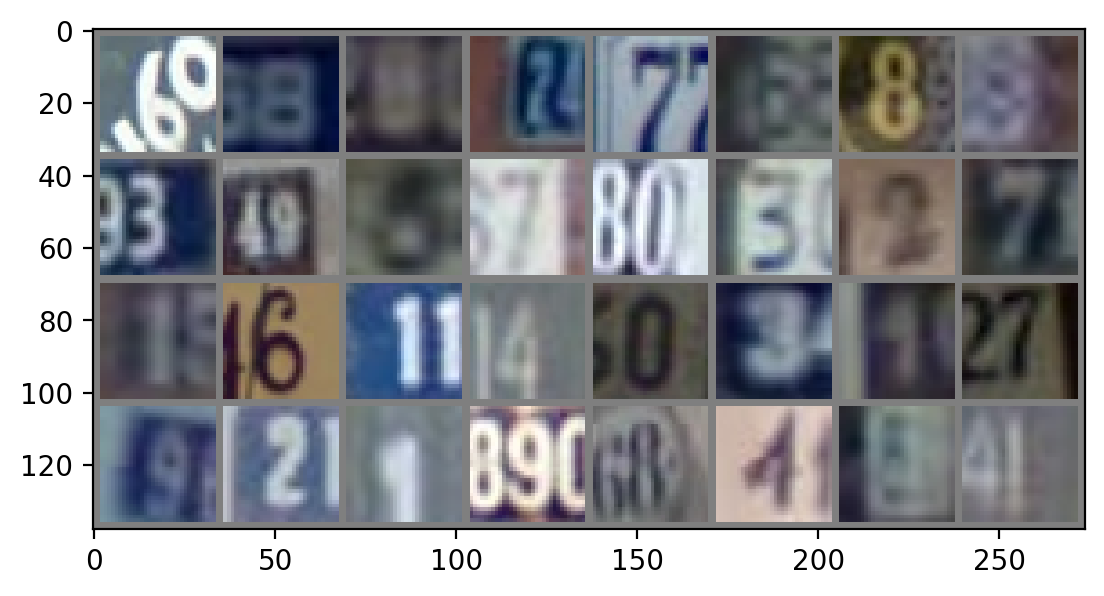

tensor([6, 8, 8, 7, 7, 6, 8, 8, 3, 9, 8, 7, 0, 3, 2, 7, 1, 6, 1, 4, 0, 3, 1, 7,
        9, 2, 0, 9, 8, 4, 8, 1])


In [ ]:
train = next(iter(trainloader_sorted))

mnist_batch_sorted, svhm_batch_sorted, mnist_labels, svhm_labels = train

imshow(torchvision.utils.make_grid(mnist_batch_sorted))

print(mnist_labels)

imshow(torchvision.utils.make_grid(svhm_batch_sorted))

print(svhm_labels)

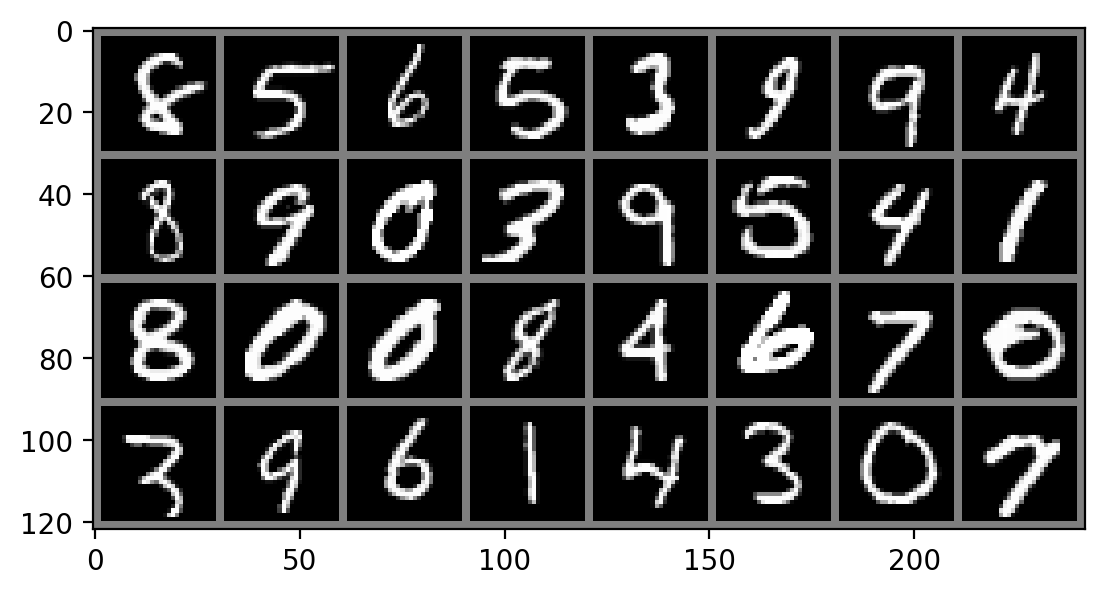

tensor([8, 5, 6, 5, 3, 9, 9, 4, 8, 9, 0, 3, 9, 5, 4, 1, 8, 0, 0, 8, 4, 6, 7, 0,
        3, 9, 6, 1, 4, 3, 0, 7])


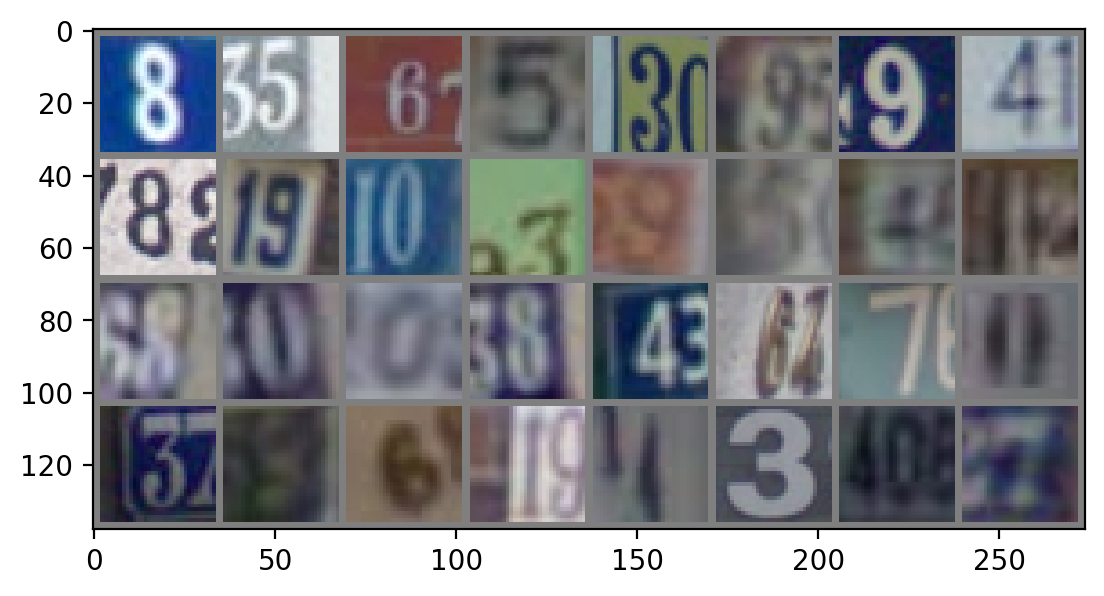

tensor([8, 5, 6, 5, 3, 9, 9, 4, 8, 9, 0, 3, 9, 5, 4, 1, 8, 0, 0, 8, 4, 6, 7, 0,
        3, 9, 6, 1, 4, 3, 0, 7])


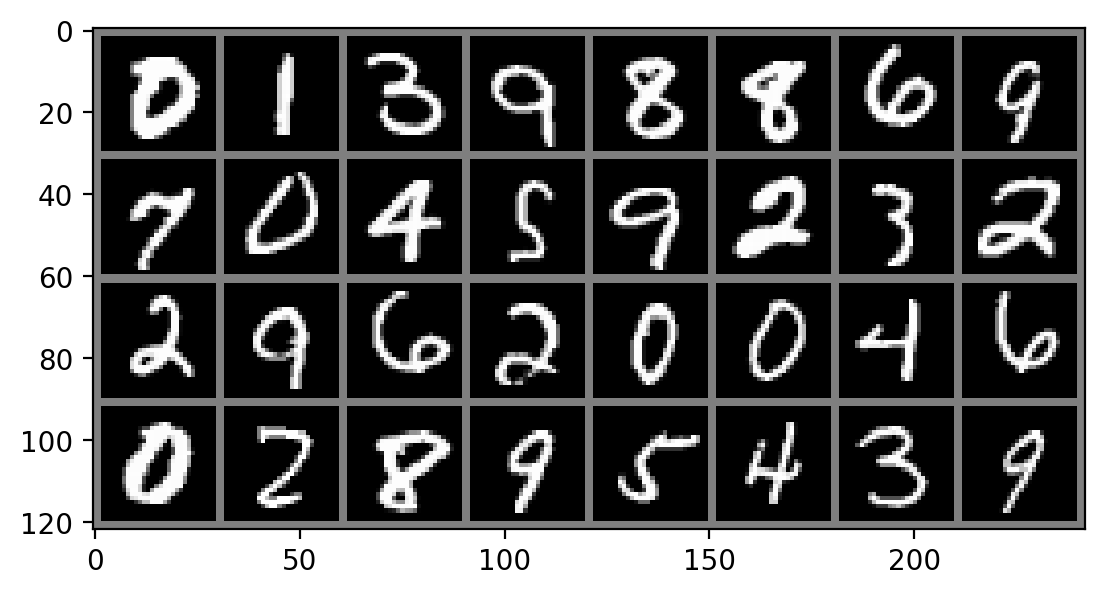

tensor([0, 1, 3, 9, 8, 8, 6, 9, 7, 0, 4, 5, 9, 2, 3, 2, 2, 9, 6, 2, 0, 0, 4, 6,
        0, 2, 8, 9, 5, 4, 3, 9])


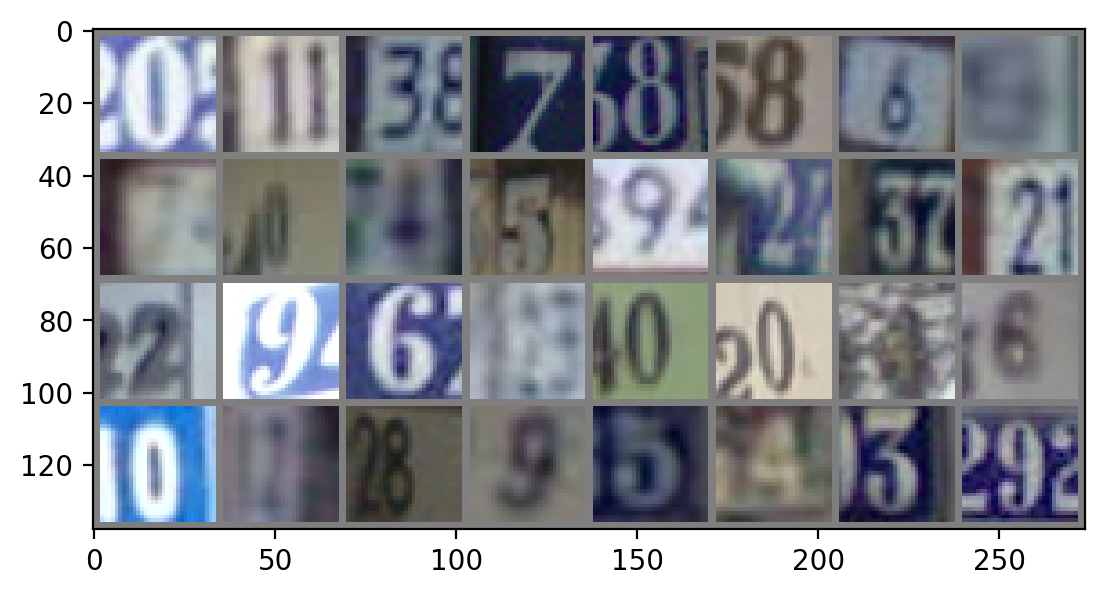

tensor([0, 1, 3, 9, 8, 8, 6, 9, 7, 0, 4, 5, 9, 2, 3, 2, 2, 9, 6, 2, 0, 0, 4, 6,
        0, 2, 8, 9, 5, 4, 3, 9])


In [ ]:
#BEFORE SUFFLING FINAL_DATASET

train = next(iter(trainloader_final))

mnist_batch_sorted, svhm_batch_sorted, mnist_labels, svhm_labels = train

imshow(torchvision.utils.make_grid(mnist_batch_sorted))

print(mnist_labels)

imshow(torchvision.utils.make_grid(svhm_batch_sorted))

print(svhm_labels)

train = next(iter(validloader_final))

mnist_batch_sorted, svhm_batch_sorted, mnist_labels, svhm_labels = train

imshow(torchvision.utils.make_grid(mnist_batch_sorted))

print(mnist_labels)

imshow(torchvision.utils.make_grid(svhm_batch_sorted))

print(svhm_labels)

## Part III: Encoder mean and variance

### MNIST

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * F.sigmoid(x)

class MNIST_encoder(nn.Module):
    '''This class corresponds to MNIST encoder. It receives as imput the dimension of the latent space.
    In this case, the number of entering channels is only one because MNIST dataset is composed of gray-scale images
    Network Inspired on: https://github.com/mhw32/multimodal-vae-public/blob/master/multimnist/model.py'''

    def __init__(self,dimz,channels=1,var_x=0.1):

        super().__init__()

        self.dimz = dimz    #dimz is k, the dimension of the latent space

        # Output Size Formula: [(W−K+2P)/S]+1
        #W = Width/Length of the image
        #K = Filter Kernel Size
        #P = Padding(Extra-Pixels in borders, normally 0s)
        #S = Stride(Steps the Kernel moves)

        #CNN ENCODER
        self.nOut = 32

        self.encode_x = nn.Sequential(
            #Input dim: [32, 32, 28, 28]
            nn.Conv2d(in_channels=channels, out_channels= self.nOut,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.nOut),
            nn.ReLU(),


            #Output dim: [32, self.nOut, 14, 14]
            nn.Conv2d(in_channels=self.nOut, out_channels= self.nOut*2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.nOut*2),
            nn.ReLU(),


            #Output dim: [32, self.nOut*2, 7, 7]
            nn.Conv2d(in_channels=self.nOut*2, out_channels= self.nOut*4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.nOut*4),
            nn.ReLU(),


            #Output dim: [32, self.nOut*4, 3, 3]
            nn.Conv2d(in_channels=self.nOut*4, out_channels= self.nOut*8,
                               kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(self.nOut*8),
            nn.ReLU()

            #Output dim: [32, self.nOut*8, 2, 2]
            )

        self.classifier = nn.Sequential(
            nn.Linear(self.nOut*8 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(512, 2*dimz)
            )

        self.softplus = nn.Softplus()


    def forward(self,x):
        z = self.encode_x(x)
        z = z.view(-1,self.nOut*8*2*2)
        z = self.classifier(z)

        return z

    def encode_and_sample(self,x,flag_sample=True):
        '''This methods compute both the posterior mean and variance.
        Furthermore, it returns a sample generated from MNIST data using reparameterization trick'''

        # We obtain the encoder projection using the forward method
        z = self.forward(x)

        # The mean is the first dimz components of the forward output

        mu = z[:, :self.dimz]

        # # We compute the variance from the last dimz components using a
        # # soft plus
        var = self.softplus(0.5 * z[:, self.dimz:])

        sample = None

        if(flag_sample==True):

            eps = torch.randn_like(var)

            sample = mu + eps*(var**0.5)

        return mu,var,sample

### SVHM

In [ ]:
class SVHM_encoder(nn.Module):
    '''This class corresponds to SVHM encoder. It receives as imput the dimension of the latent space.
    In this case, the number of entering channels is only one because SVHM dataset is composed of gray-scale images'''

    def __init__(self,dimz,channels=3,var_x=0.1):

        super().__init__()

        self.dimz = dimz    #dimz is k, the dimension of the latent space

        # Output Size Formula: [(W−K+2P)/S]+1
        #W = Width/Length of the image
        #K = Filter Kernel Size
        #P = Padding(Extra-Pixels in borders, normally 0s)
        #S = Stride(Steps the Kernel moves)

        self.nOut = 32

        #ORIGINAL IMAGES (Network inspired on: https://github.com/axium/VAE-SVHN/blob/master/VAE%20-%20SVHN.ipynb)
        # self.encode_x = nn.Sequential(
        #   #Input dim: [32, 1, 32, 32]
        #   nn.Conv2d(in_channels=channels, out_channels= self.nOut,
        #                     kernel_size=2, stride=2, padding=0),
        #   nn.BatchNorm2d(self.nOut),
        #   nn.ReLU(),


        #   #Output dim: [32, self.nOut, 16, 16]
        #   nn.Conv2d(in_channels=self.nOut, out_channels= self.nOut*2,
        #                     kernel_size=2, stride=2, padding=0),
        #   nn.BatchNorm2d(self.nOut*2),
        #   nn.ReLU(),


        #   # #Output dim: [32, self.nOut*2, 8, 8]
        #   nn.Conv2d(in_channels=self.nOut*2, out_channels= self.nOut*4,
        #                     kernel_size=2, stride=2, padding=0),
        #   nn.BatchNorm2d(self.nOut*4),
        #   nn.ReLU(),

        #   #Output dim: [32, self.nOut*4, 4, 4]
        #   )


        #ORIGINAL ENCODER 64x64 IMAGES
        self.encode_x = nn.Sequential(
            #Input dim: [32, 1, 64, 64]
            nn.Conv2d(in_channels=channels, out_channels= 32,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),


            #Output dim: [32, 32, 32, 32]
            nn.Conv2d(in_channels=32, out_channels= 32,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),


            #Output dim: [32, 32, 16, 16]
            nn.Conv2d(in_channels=32, out_channels= 64,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),


            #Output dim: [32, 64, 8, 8]
            nn.Conv2d(in_channels=64, out_channels= 64,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),


            #Output dim: [32, 64, 4, 4]
            nn.Conv2d(in_channels=64, out_channels= 256,
                               kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()

            #Output dim: [32, 256, 1, 1]
            )


        # self.linear is a linear layer with dimz*2 outputs
        #self.linear = nn.Linear(self.nOut*4*4*4,2*dimz)
        self.linear = nn.Linear(256,2*dimz)

        self.relu = nn.ReLU()

        self.softplus = nn.Softplus()


    def forward(self,x):
        '''The forward method to project and image into a 2dimz dimensional vector'''

        #ORIGINAL
        # z = self.encode_x(x)

        # z = z.view(-1,self.nOut*4*4*4)
        # z = self.linear(z)


        #ORIGINAL ENCODER 64x64 IMAGES
        z = self.encode_x(x)

        z = z.view(-1,256)
        z = self.linear(z)

        return z

    def encode_and_sample(self,x,flag_sample=True):
        '''This methods compute both the posterior mean and variance.
        Furthermore, it returns a sample generated from SVHM data using reparameterization trick'''

        # We obtain the encoder projection using the forward method
        z = self.forward(x)

        # The mean is the first dimz components of the forward output

        mu = z[:, :self.dimz]

        # We compute the variance from the last dimz components using a
        # soft plus
        var = self.softplus(0.5 * z[:, self.dimz:])

        sample = None

        if(flag_sample==True):

            eps = torch.randn_like(var)

            sample = mu + eps*(var**0.5)

        return mu,var,sample

## Part IV: Decoder Mean

### MNIST

In [ ]:
class MNIST_decoder(nn.Module):

    def __init__(self,dimz,channels=1,var_x=0.1):

        super().__init__()

        self.dimz = dimz

        #CNN DECODER
        self.nOut = 32

        self.decode_z = nn.Sequential(

            nn.ConvTranspose2d(in_channels=self.nOut*8, out_channels=self.nOut*4,
                               kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(self.nOut*4),
            nn.ReLU(),


            nn.ConvTranspose2d(in_channels=self.nOut*4, out_channels=self.nOut*2,
                               kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(self.nOut*2),
            nn.ReLU(),


            nn.ConvTranspose2d(in_channels=self.nOut*2, out_channels= self.nOut,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.nOut),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=self.nOut, out_channels=channels ,
                               kernel_size=4, stride=2, padding=1),
            #nn.Sigmoid()
            nn.Tanh()
            )

        self.linear = nn.Linear(dimz,self.nOut*8*2*2)

        self.ReLU = nn.ReLU()


    def forward(self,z):
        x = self.ReLU(self.linear(z).view(-1,self.nOut*8,2,2))
        x = self.decode_z(x)
        return x

    def decode(self,z):

        # This function simply calls the forward method

        return self.forward(z)

torch.Size([32, 2])
torch.Size([32, 1, 28, 28])


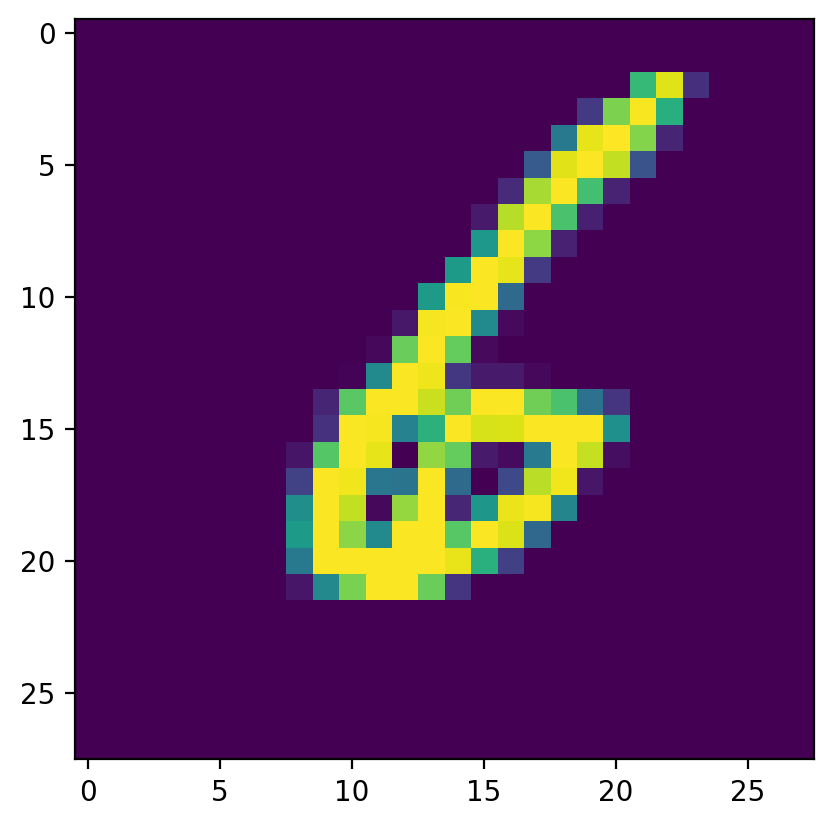

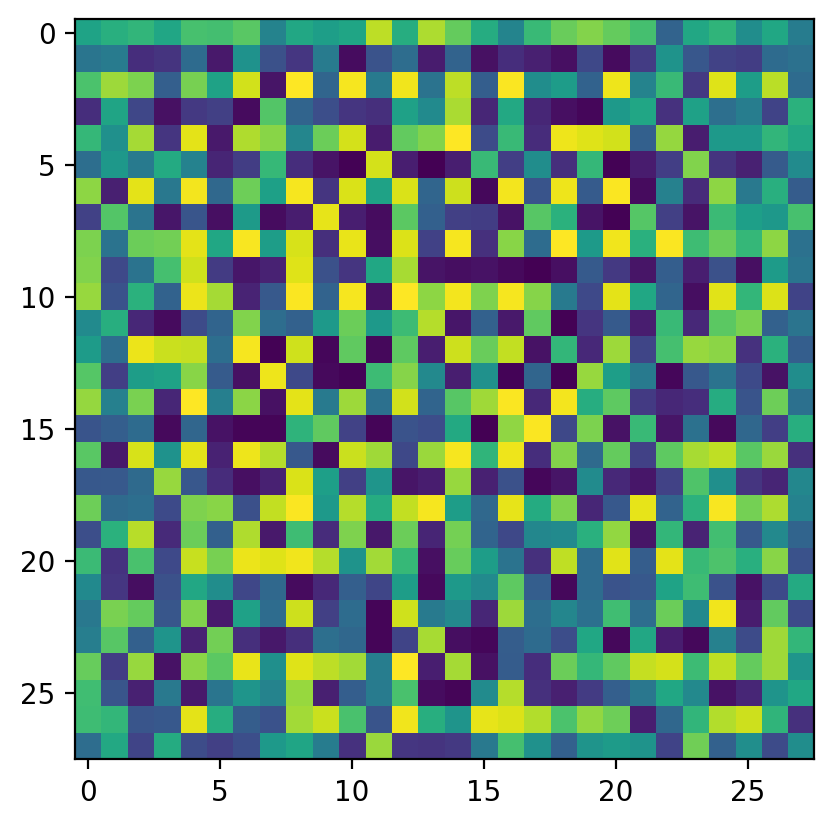

In [ ]:
i,l = next(iter(mnist_trainloader))

dim_z = 2
mnist_enc = MNIST_encoder(dimz = dim_z)
mnist_dec = MNIST_decoder(dimz = dim_z)
mu,var_z,sample_z=mnist_enc.encode_and_sample(i)

print(mu.shape)

x = mnist_dec.forward(mu).detach()

print(x.shape)

imshow(i[0,:,:,:])
imshow(x[0,:,:,:])

### SVHM

In [ ]:
class SVHM_decoder(nn.Module):

    def __init__(self,dimz,channels=3,var_x=0.1):

        super().__init__()

        # We expand z into a 256 dimensional vector

        self.nOut = 32

        # self.decode_z = nn.Sequential(

        #     nn.ConvTranspose2d(in_channels=self.nOut*4, out_channels=self.nOut*4,
        #                        kernel_size=2, stride=2, padding=0),
        #     nn.BatchNorm2d(self.nOut*4),
        #     nn.ReLU(),


        #     nn.ConvTranspose2d(in_channels=self.nOut*4, out_channels=self.nOut*2,
        #                        kernel_size=2, stride=2, padding=0),
        #     nn.BatchNorm2d(self.nOut*2),
        #     nn.ReLU(),


        #     nn.ConvTranspose2d(in_channels=self.nOut*2, out_channels=self.nOut,
        #                        kernel_size=2, stride=2, padding=0),
        #     nn.BatchNorm2d(self.nOut),
        #     nn.ReLU(),


        #     nn.ConvTranspose2d(in_channels=self.nOut, out_channels=channels,
        #                        kernel_size=1, stride=1, padding=0),

        #     #nn.Sigmoid()
        #     nn.Tanh()
        #     )


        #ORIGINAL DECODER 64x64 IMAGES
        self.decode_z = nn.Sequential(

            nn.ConvTranspose2d(in_channels=256, out_channels=64,
                               kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.LeakyReLU(0.2),


            nn.ConvTranspose2d(in_channels=64, out_channels=64,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.LeakyReLU(0.2),


            nn.ConvTranspose2d(in_channels=64, out_channels=32,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.LeakyReLU(0.2),


            nn.ConvTranspose2d(in_channels=32, out_channels= 32,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.LeakyReLU(0.2),


            nn.ConvTranspose2d(in_channels=32, out_channels=channels ,
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            )

        # self.linear = nn.Linear(dimz,self.nOut*4*4*4)
        self.linear = nn.Linear(dimz,256)

        self.ReLU = nn.ReLU()

    def forward(self,z):
        #ORIGINAL IMAGES
        # x = self.ReLU(self.linear(z).view(-1,self.nOut*4,4,4))
        # x = self.decode_z(x)

        #ORIGINAL DECODER 64x64 IMAGES
        x = self.ReLU(self.linear(z).view(-1,256,1,1))
        x = self.decode_z(x)
        return x

    def decode(self,z):

        # This function simply calls the forward method

        return self.forward(z)

torch.Size([32, 2])
torch.Size([32, 3, 64, 64])


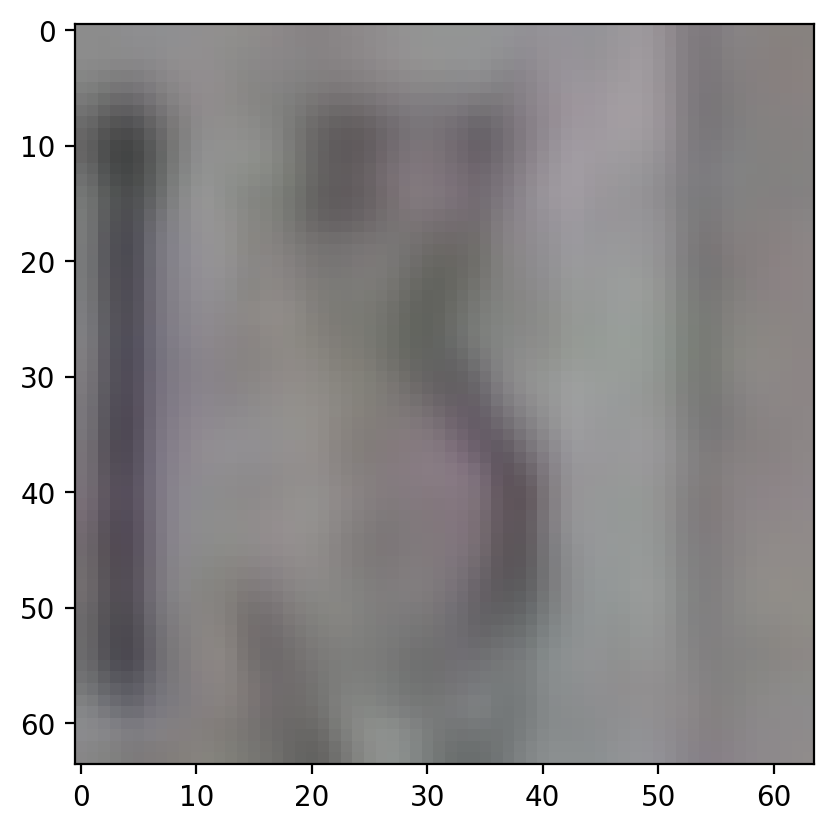

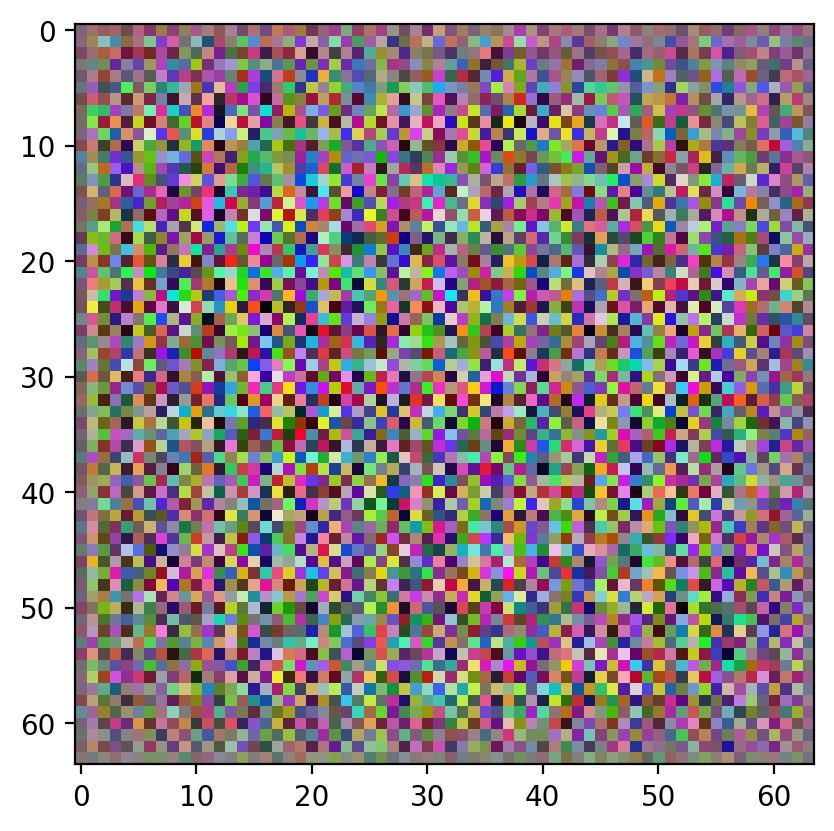

In [ ]:
i,l = next(iter(svhm_trainloader))

dim_z = 2
mnist_enc = SVHM_encoder(dimz = dim_z)
mnist_dec = SVHM_decoder(dimz = dim_z)
mu,var_z,sample_z=mnist_enc.encode_and_sample(i)

print(mu.shape)

x = mnist_dec.forward(mu).detach()

print(x.shape)

imshow(i[0,:,:,:])
imshow(x[0,:,:,:])

## Part V: VAEs Loss Function

In [ ]:
def eval_Gaussian_LL(x,mu_x,var_x):

    # x is a mini-batch of images.

    # mu_x is a mini-batch of reconstructed images.

    # var_x is a torch constant

    D = x.shape[1] * x.shape[2] * x.shape[3]   # Dimension of the image

    x = x.reshape(-1, D)

    mu_x = mu_x.reshape(-1, D)

    var_x = torch.ones_like(mu_x) * var_x

    # Constant term in the gaussian distribution
    cnt = D * np.log(2 * np.pi) + torch.sum(torch.log(var_x), dim=-1)

    # log-likelihood per datapoint

    logp_data = -0.5 * (cnt + torch.sum((x - mu_x) * var_x ** -1 * (x - mu_x), dim=-1))

    # Accumulated Gaussian log-likelihood for all datapoints in the batch
    logp = torch.sum(logp_data)

    return logp,logp_data

torch.Size([32, 10])


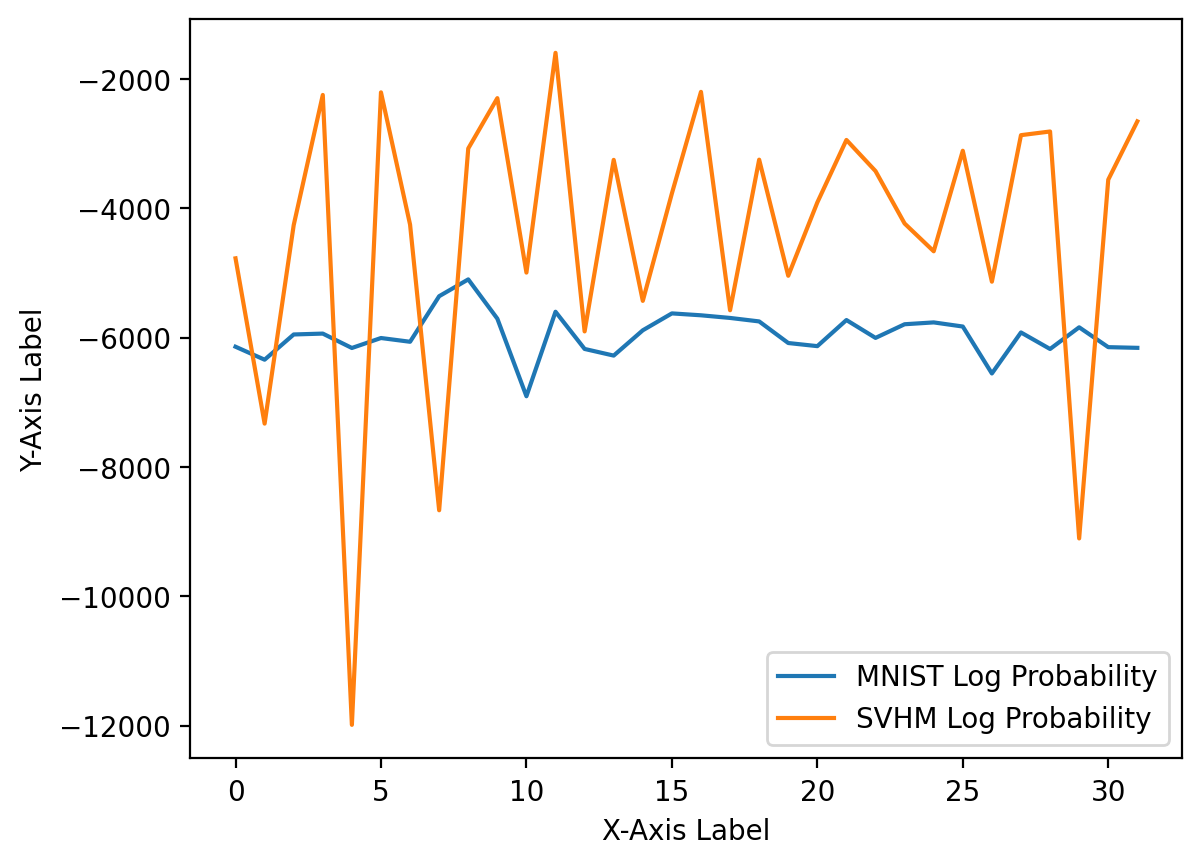

In [ ]:
var_x = 0.1

mnist_i,l = next(mnist_train)
svhm_i,l = next(svhm_train)

mnist_mu_z,mnist_var_z,mnist_sample = mnist_enc.encode_and_sample(mnist_i)
svhm_mu_z,svhm_var_z,svhm_sample = svhm_enc.encode_and_sample(svhm_i)

#Mixture of Experts (MoD)
mu_z = 0.5*mnist_mu_z + 0.5*svhm_mu_z
var_z = 0.5*mnist_var_z + 0.5*mnist_var_z

#Sample from posterior
eps = torch.randn_like(var_z)
sample_z = mu_z + eps*(var_z**0.5)

mnist_x_mean = mnist_dec.decode(sample_z).detach()
svhm_x_mean = svhm_dec.decode(sample_z).detach()

mnist_logp,mnist_logp_data = eval_Gaussian_LL(x=mnist_i,mu_x=mnist_x_mean,var_x=var_x)
svhm_logp,svhm_logp_data = eval_Gaussian_LL(x=svhm_i,mu_x=svhm_x_mean,var_x=var_x)

# Create the plot for mnist_logp_data and add a label
plt.plot(np.arange(0, 32), mnist_logp_data, label='MNIST Log Probability')

# Create the plot for svhm_logp_data and add a label
plt.plot(np.arange(0, 32), svhm_logp_data, label='SVHM Log Probability')

# Add labels to the x-axis and y-axis
plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')

# Add a legend to the plot to distinguish between the two lines
plt.legend()

# Show the plot
plt.show()

## Part VI: VAE for MNIST and SVHM

In [ ]:
class VAE(nn.Module):

    def __init__(self, dimz, var_x=0.1, dataset = 'SVHM'):

        super().__init__()

        self.dimz = dimz
        self.var_x = var_x

        self.MNIST_channels = 1
        #ORIGINAL
        # self.SVHM_channels = 3
        self.SVHM_channels = 1


        if dataset != 'SVHM':
            # We create an encoder network
            self.encoder = MNIST_encoder(self.dimz,self.MNIST_channels,var_x)
            # We create a decoder network
            self.decoder = MNIST_decoder(self.dimz,self.MNIST_channels,var_x)


        else:
            # We create an encoder network
            self.encoder = SVHM_encoder(self.dimz,self.SVHM_channels,var_x)
            # We create a decoder network
            self.decoder = SVHM_decoder(self.dimz,self.SVHM_channels,var_x)


    def forward(self,x):

        # In the forward method, we return the mean and variance
        # given by the encoder network and also the reconstruction mean
        # given by the decoder network using a sample from the
        # encoder's posterior distribution.

        mu_z,var_z,sample_z = self.encoder.encode_and_sample(x) #YOUR CODE HERE

        # Decoder provides the mean of the reconstruction

        mu_x = self.decoder.decode(sample_z)

        return mu_x,mu_z,var_z

    # Reconstruction + KL divergence losses summed over all elements and batch

    def loss_function(self, x, mu_x, mu_z, var_z):

        # We evaluate the loglikelihood in the batch using the function provided above

        logp,_ = eval_Gaussian_LL(x,mu_x,self.var_x)

        # KL divergence between q(z) and N()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114

        KLz = -0.5 * torch.sum(1 + torch.log(var_z) - mu_z.pow(2) - var_z)

        # To maximize ELBO we minimize loss (-ELBO)
        return -logp + KLz, -logp, KLz

#### __LOSS FUNCTION TEST__

In [ ]:
mnist_i,l = next(mnist_train)
svhm_i,l = next(svhm_train)

my_vae = VAE(dimz=20, dataset = 'MNIST') #20D Based on Paper

mu_x,mu_z,var_z = my_vae.forward(mnist_i)

print(f'MNIST LOSS: {my_vae.loss_function(mnist_i,mu_x,mu_z,var_z)}')

my_vae = VAE(dimz=20) #20D Based on Paper

mu_x,mu_z,var_z = my_vae.forward(svhm_i)

print(f'SVHM LOSS: {my_vae.loss_function(svhm_i,mu_x,mu_z,var_z)}')

MNIST LOSS: (tensor(137921.6094, grad_fn=<AddBackward0>), tensor(137901.5938, grad_fn=<NegBackward0>), tensor(20.0151, grad_fn=<MulBackward0>))
SVHM LOSS: (tensor(202921.9219, grad_fn=<AddBackward0>), tensor(202902.7500, grad_fn=<NegBackward0>), tensor(19.1665, grad_fn=<MulBackward0>))


### __VAE TRAINING METHOD__

In [ ]:
class VAE_extended(VAE):

    def __init__(self, dimz=2, var_x=0.1,lr=1e-3,epochs=20,dataset='SVHM',save_folder='./',restore=False):

        super().__init__(dimz,var_x=0.1,dataset=dataset)

        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.dataset = dataset
        self.plot = False

        self.save_folder = save_folder

        if(restore==True):
          if self.dataset != 'SVHM':
            state_dict = torch.load(self.save_folder+'MNIST_VAE_checkpoint.pth', map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
          else:
            state_dict = torch.load(self.save_folder+'SVHM_VAE_checkpoint.pth', map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
          self.load_state_dict(state_dict)

        self.loss_during_training = []
        self.reconstruc_during_training = []
        self.KL_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self,trainloader):

        self.train()

        idx_all = np.arange(len(trainloader))
        loss_ev = np.zeros(len(trainloader))

        for e in range(int(self.epochs)):

            train_loss = 0
            train_rec = 0
            train_kl_l = 0

            idx_batch = 0

            for images, labels in tqdm(trainloader):

                images = images.to(self.device)

                self.optim.zero_grad()

                mu_x, mu_z, var_z = self.forward(images)

                loss, rec, kl_l = self.loss_function(images,mu_x, mu_z, var_z)

                loss.backward()

                train_loss += loss.item()
                train_rec += rec.item()
                train_kl_l += kl_l.item()

                self.optim.step()

                if(idx_batch%10==0):

                  if self.dataset != 'SVHM':
                    torch.save(self.state_dict(), self.save_folder + 'MNIST_VAE_checkpoint.pth')
                  else:
                    torch.save(self.state_dict(), self.save_folder + 'SVHM_VAE_checkpoint.pth')

                loss_ev[idx_batch] = loss.item()
                idx_batch += 1

            self.loss_during_training.append(train_loss/len(trainloader))
            self.reconstruc_during_training.append(train_rec/len(trainloader))
            self.KL_during_training.append(train_kl_l/len(trainloader))

            if(e%1==0):
                if self.dataset != 'SVHM':
                  torch.save(self.state_dict(), self.save_folder + 'MNIST_VAE_checkpoint.pth')
                else:
                  torch.save(self.state_dict(), self.save_folder + 'SVHM_VAE_checkpoint.pth')

                if self.plot:
                  # Crear un gráfico de línea
                  plt.plot(idx_all[::50], loss_ev[::50], marker='o', linestyle='-')

                  # Etiquetas y título
                  plt.xlabel('idx_batch')
                  plt.ylabel('Valor de Loss')

                  # Mostrar el gráfico
                  plt.grid()  # Habilita la cuadrícula
                  plt.show()

                print('Train Epoch: {} \tLoss: {:.6f}'.format(e,self.loss_during_training[-1]))


    def sample(self,num_imgs):

      with torch.no_grad():

        eps = torch.randn([num_imgs,self.dimz]).to(self.device)

        x_sample = self.decoder.decode(eps)

        return x_sample.to("cpu").detach()

### MNIST

In [ ]:
#ORIGINAL
mnist_vae = VAE_extended(dimz=2, var_x=0.1, lr=1e-3,epochs=20,dataset='MNIST',save_folder=path_to_folder,restore=True)

mnist_vae.trainloop(mnist_trainloader)
#LAST LOSS:
#dimz=10:-3452.017929
#dimz=20:-3558.595250
#dimz=33:-3573.211126
#dimz=50:-3548.825164
#dimz=64:-3576.118382

100%|██████████| 1875/1875 [00:26<00:00, 71.61it/s]


Train Epoch: 0 	Loss: 166.563126


100%|██████████| 1875/1875 [00:21<00:00, 86.54it/s]


Train Epoch: 1 	Loss: -395.912470


100%|██████████| 1875/1875 [00:29<00:00, 62.86it/s]


Train Epoch: 2 	Loss: -611.959130


100%|██████████| 1875/1875 [00:27<00:00, 68.16it/s]


Train Epoch: 3 	Loss: -729.393224


100%|██████████| 1875/1875 [00:27<00:00, 69.22it/s]


Train Epoch: 4 	Loss: -817.290254


100%|██████████| 1875/1875 [00:22<00:00, 84.90it/s]


Train Epoch: 5 	Loss: -878.520606


100%|██████████| 1875/1875 [00:21<00:00, 87.43it/s]


Train Epoch: 6 	Loss: -919.510130


100%|██████████| 1875/1875 [00:21<00:00, 85.93it/s]


Train Epoch: 7 	Loss: -960.780721


100%|██████████| 1875/1875 [00:21<00:00, 85.69it/s]


Train Epoch: 8 	Loss: -990.667141


100%|██████████| 1875/1875 [00:22<00:00, 83.73it/s]


Train Epoch: 9 	Loss: -1011.232663


100%|██████████| 1875/1875 [00:21<00:00, 85.87it/s]


Train Epoch: 10 	Loss: -1035.764957


100%|██████████| 1875/1875 [00:20<00:00, 89.96it/s]


Train Epoch: 11 	Loss: -1060.785615


100%|██████████| 1875/1875 [00:21<00:00, 85.62it/s]


Train Epoch: 12 	Loss: -1079.204040


100%|██████████| 1875/1875 [00:21<00:00, 87.95it/s]


Train Epoch: 13 	Loss: -1095.857717


100%|██████████| 1875/1875 [00:21<00:00, 85.54it/s]


Train Epoch: 14 	Loss: -1102.720366


100%|██████████| 1875/1875 [00:28<00:00, 66.91it/s]


Train Epoch: 15 	Loss: -1122.423172


100%|██████████| 1875/1875 [00:22<00:00, 84.17it/s]


Train Epoch: 16 	Loss: -1124.146937


100%|██████████| 1875/1875 [00:20<00:00, 89.37it/s]


Train Epoch: 17 	Loss: -1137.880008


100%|██████████| 1875/1875 [00:22<00:00, 84.24it/s]


Train Epoch: 18 	Loss: -1164.487157


100%|██████████| 1875/1875 [00:21<00:00, 86.61it/s]


Train Epoch: 19 	Loss: -1169.592265


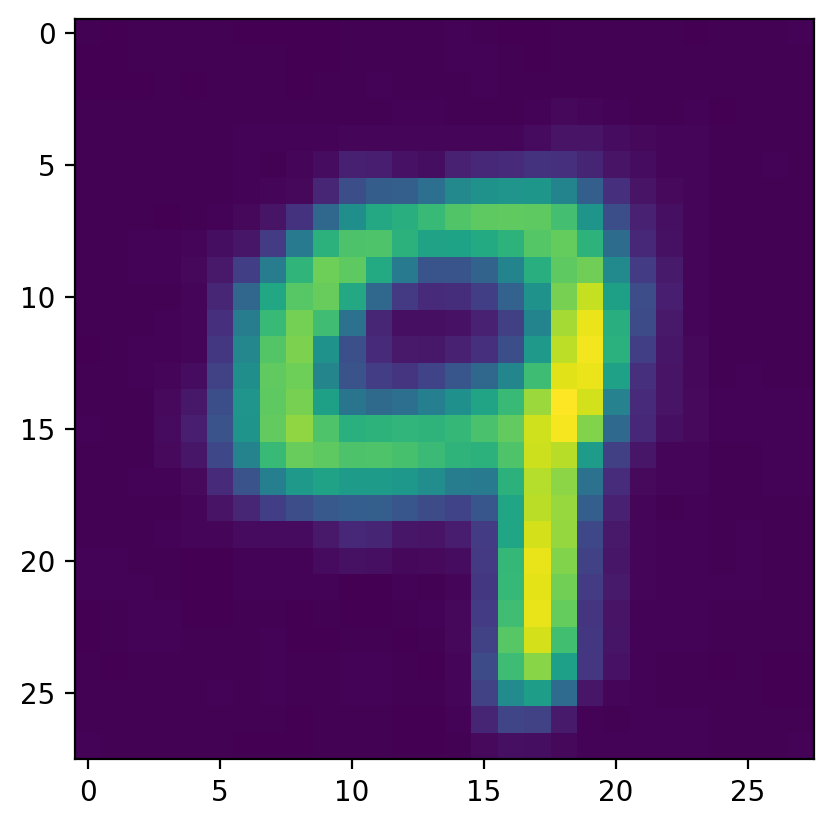

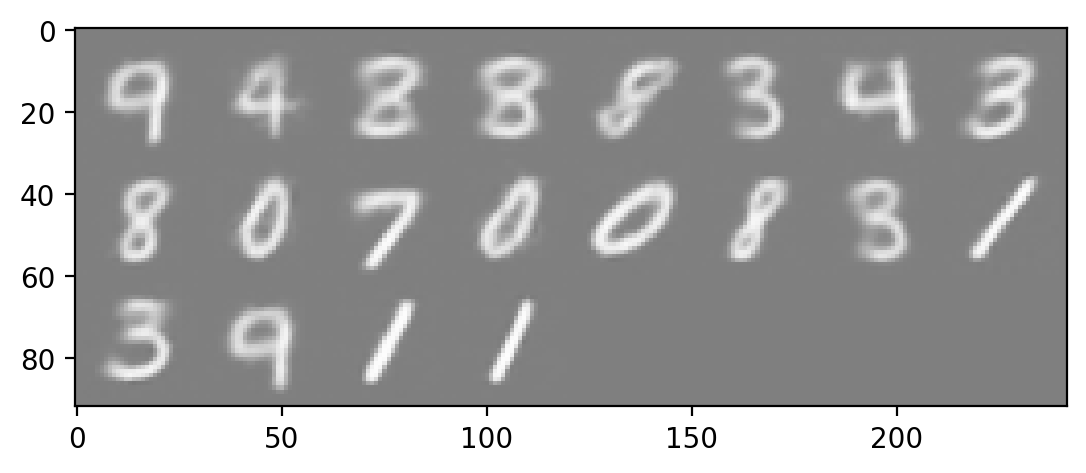

In [ ]:
#ORIGINAL
x = mnist_vae.sample(20)

imshow(x[0,:,:,:])

imshow(torchvision.utils.make_grid(x))

As we can see, with just 10 epochs, we almost recovered every number with a decent resolution which make them recognizable. Furthermore, we tried several latent space dimension which returns different outputs in terms of loss (dim_z = 64 seems better) and image resolution (dimz=10 are more recognizable). Therefore, in terms of recognize images I would choose small values for the latent dimension.

Let's visualize how the images are displayed along the latent space:

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def rescale(img):
    img = img / 2 + 0.5     # unnormalize to plot
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_latent_space_with_images(images,latent,xmin=-150,xmax=150,ymin=-150,ymax=150):

    # images --> Minibatch of images (numpy array!)
    # latent --> Matrix of 2D representations (numpy array!)

    f, ax = plt.subplots(1,1,figsize=(8, 8))
    # ax is a figure handle
    ax.clear()
    for i in range(len(images)):
        im = OffsetImage(rescale(images[i,:,:,:]))
        ab = AnnotationBbox(im, latent[i,:],frameon=False)
        ax.add_artist(ab)
    #We set the limits according to the maximum and minimum values found for the latent projections
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_title('Latent space Z with Images')

In [ ]:
#TODO
from sklearn.manifold import TSNE

# Apply TSNE over z_batch
train = iter(mnist_trainloader)

i,l = next(train)

imshow(torchvision.utils.make_grid(i))

z_batch,_,_ = mnist_vae.encoder.encode_and_sample(i.to(mnist_vae.device),flag_sample=False)

latent_tsne = TSNE(n_components=2).fit_transform(z_batch.to('cpu').detach().numpy())

#TODO WHY ONLY ONE IMAGE
plot_latent_space_with_images(i, latent_tsne)

### SVHM

In [ ]:
svhm_vae = VAE_extended(dimz=10, var_x=0.1, lr=1e-3,epochs=10,dataset='SVHM',save_folder=path_to_folder,restore=False)

svhm_vae.trainloop(svhm_trainloader) #LAST LOSS -46847.201010

100%|██████████| 2290/2290 [01:12<00:00, 31.58it/s]


Train Epoch: 0 	Loss: -24239.882332


100%|██████████| 2290/2290 [01:12<00:00, 31.45it/s]


Train Epoch: 1 	Loss: -41315.912362


100%|██████████| 2290/2290 [01:10<00:00, 32.63it/s]


Train Epoch: 2 	Loss: -42811.962325


100%|██████████| 2290/2290 [01:10<00:00, 32.58it/s]


Train Epoch: 3 	Loss: -43751.060941


100%|██████████| 2290/2290 [01:09<00:00, 33.03it/s]


Train Epoch: 4 	Loss: -44601.812724


100%|██████████| 2290/2290 [01:09<00:00, 33.02it/s]


Train Epoch: 5 	Loss: -45214.539629


100%|██████████| 2290/2290 [01:09<00:00, 32.96it/s]


Train Epoch: 6 	Loss: -45720.059795


100%|██████████| 2290/2290 [01:11<00:00, 32.14it/s]


Train Epoch: 7 	Loss: -46240.131906


100%|██████████| 2290/2290 [01:08<00:00, 33.25it/s]


Train Epoch: 8 	Loss: -46618.156676


100%|██████████| 2290/2290 [01:09<00:00, 33.10it/s]

Train Epoch: 9 	Loss: -46973.219275


100%|██████████| 2290/2290 [01:10<00:00, 32.62it/s]


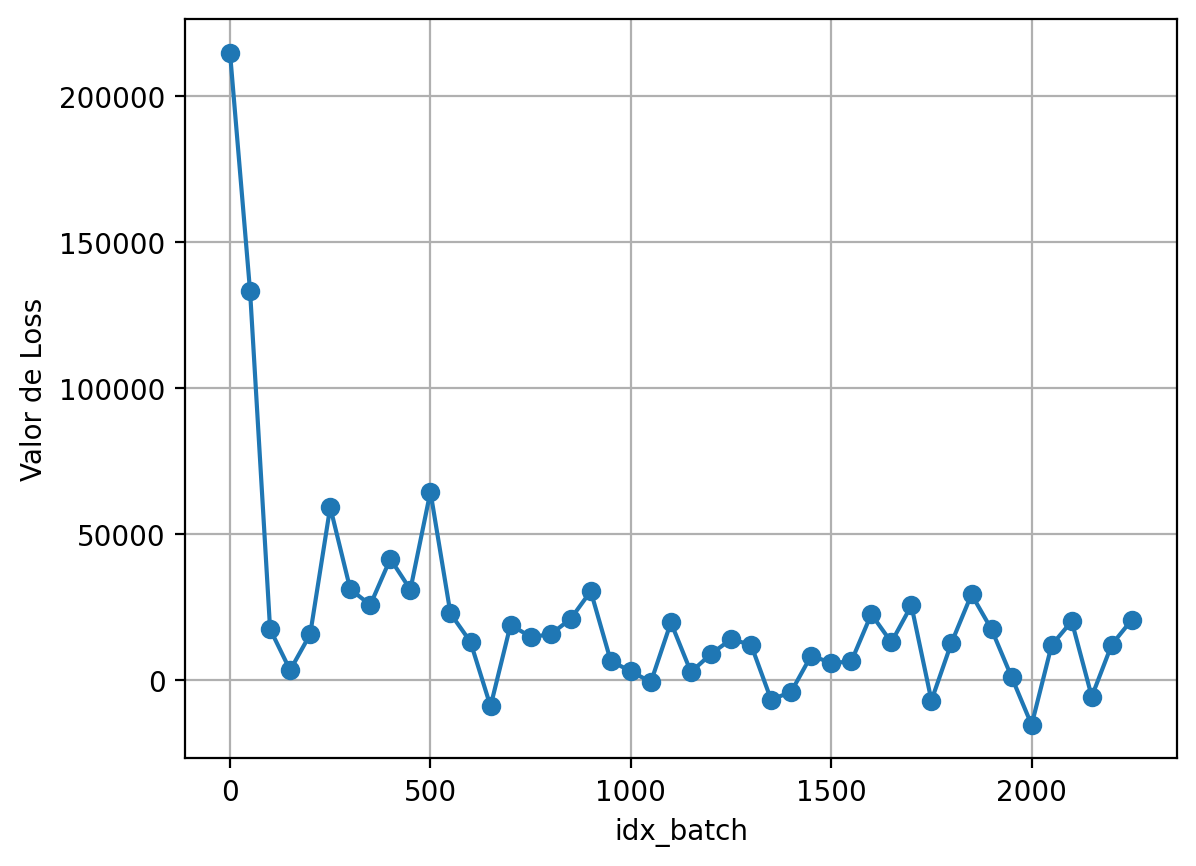

Train Epoch: 0 	Loss: 18882.867238


100%|██████████| 2290/2290 [01:09<00:00, 33.09it/s]


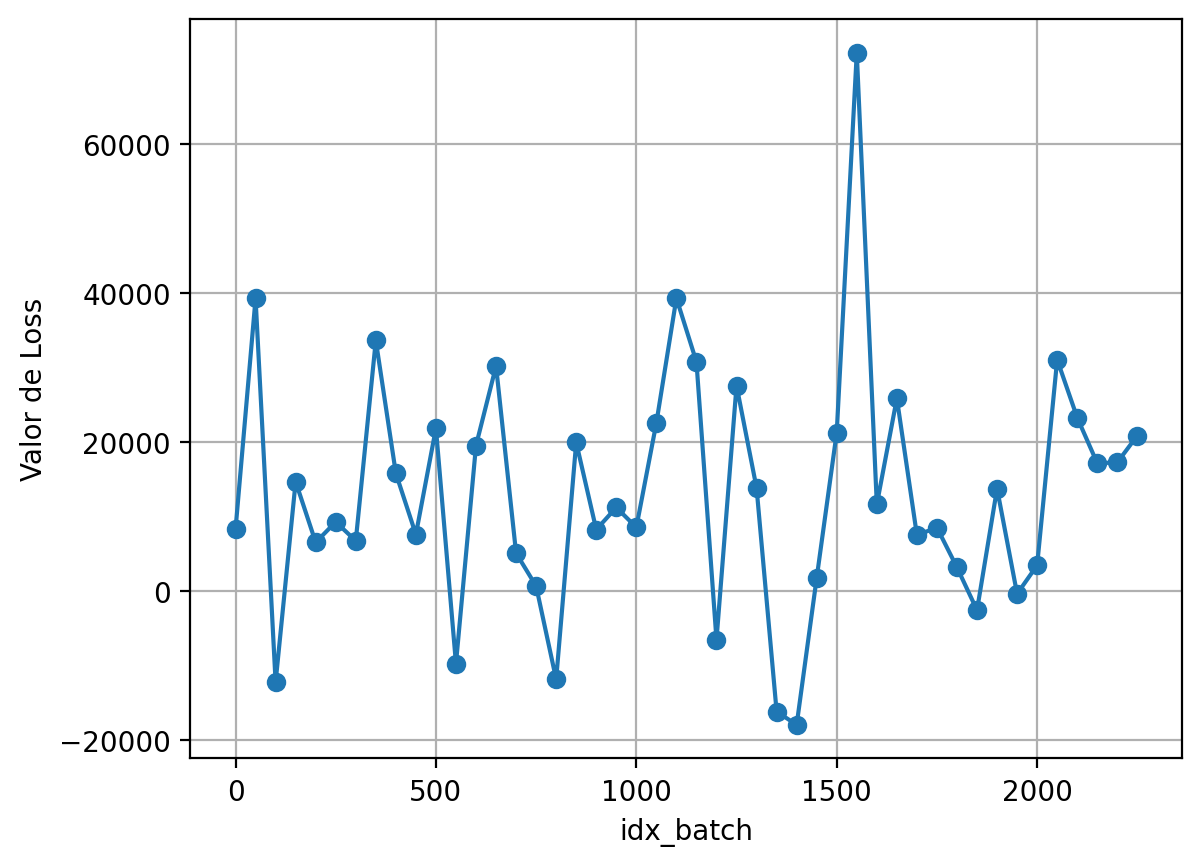

Train Epoch: 1 	Loss: 9816.504727


100%|██████████| 2290/2290 [01:08<00:00, 33.56it/s]


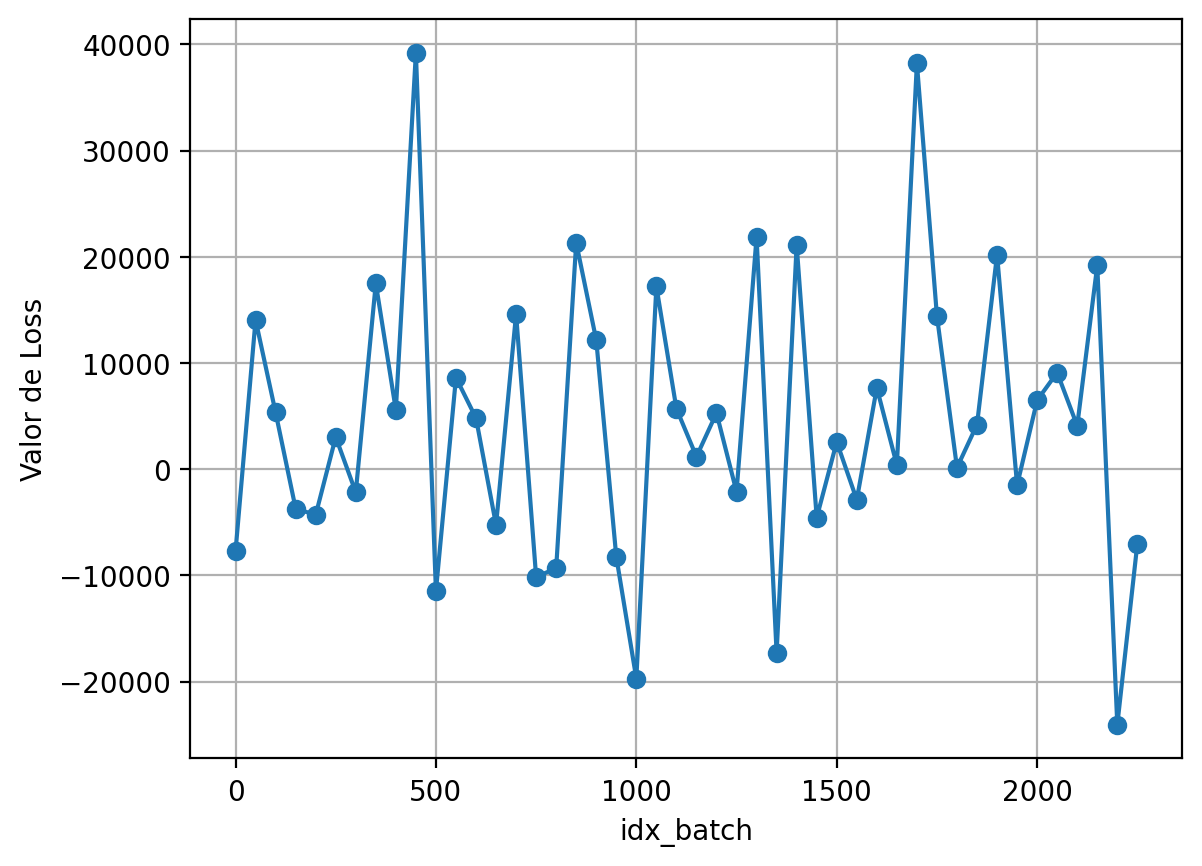

Train Epoch: 2 	Loss: 8164.819247


In [ ]:
svhm_vae = VAE_extended(dimz=2, var_x=0.1, lr=1e-3,epochs=3,dataset='SVHM',save_folder=path_to_folder,restore=False)
svhm_vae.plot = True
svhm_vae.trainloop(svhm_trainloader)

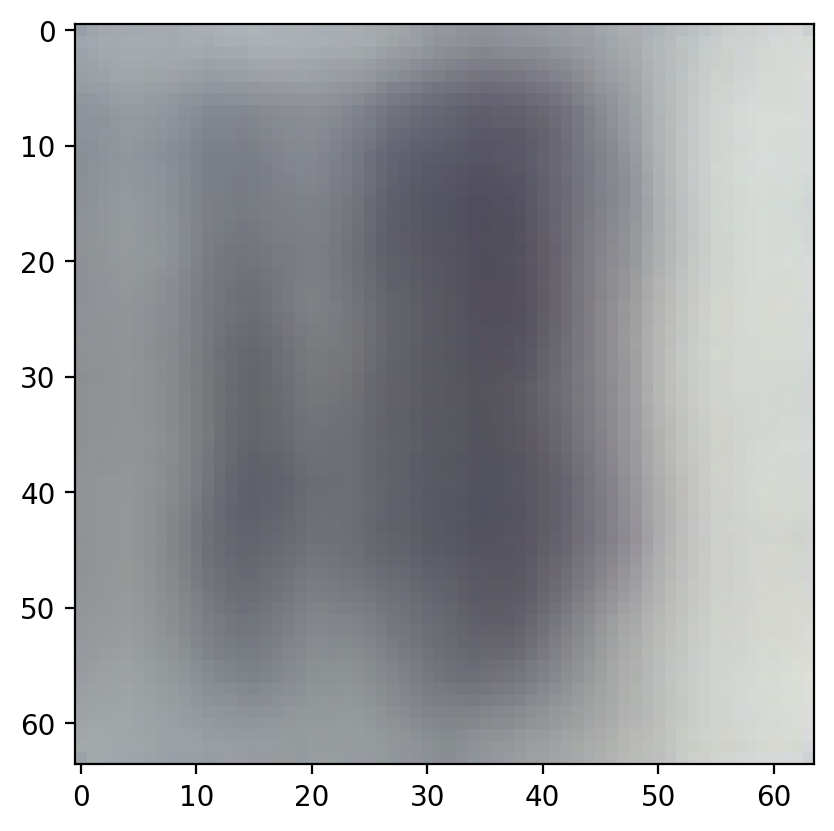

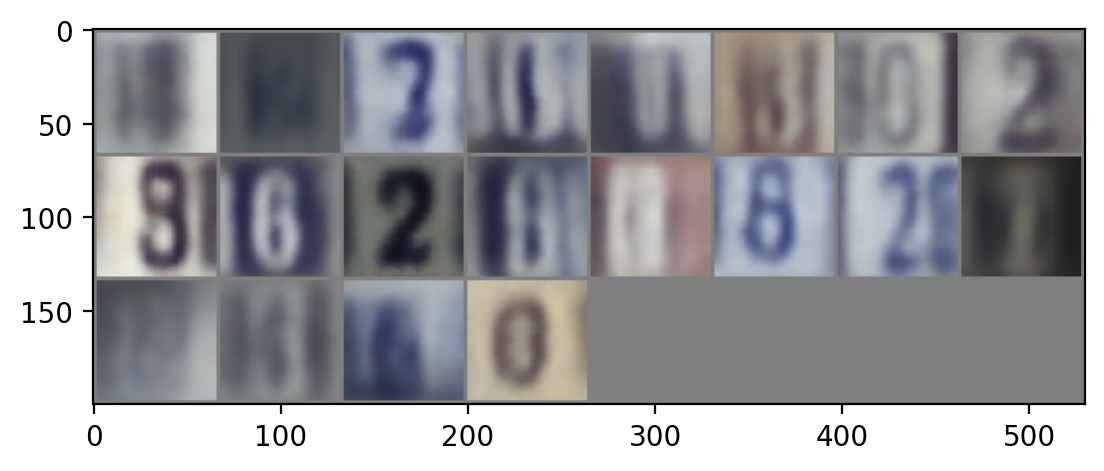

In [ ]:
#ORIGINAL
x = svhm_vae.sample(20)

imshow(x[0,:,:,:])

imshow(torchvision.utils.make_grid(x))

On the other hand, with just 10 epochs, it is less sharp compared to MNIST, but we have to take into account that the original dataset is also dificult to recognize, so this task has been good developed by the VAE, despite probably after some more epochs the result would be even better. Moreover, for this dataset it is interesting to provide higher values for the latent dimension in order to find more color and number variety. For example, using dimz=2, most of the sampled images were blue and the same numbers were repeated in several images. In contrast, dimz=256 captured properly the colors of the image but the numbers were unreal.

Let's visualize how this SVHM images are displayed along the latent space:

In [ ]:
#TODO

# Apply TSNE over z_batch
train = iter(svhm_trainloader)

i,l = next(train)

imshow(torchvision.utils.make_grid(i))

z_batch,_,_ = svhm_vae.encoder.encode_and_sample(x=i.to(svhm_vae.device),flag_sample=False)

latent_tsne = TSNE(n_components=2).fit_transform(z_batch.to('cpu').detach().numpy())

plot_latent_space_with_images(i, latent_tsne)

## Part VII: Multi-View VAE Training function

In [ ]:
class MVAE(nn.Module):

    def __init__(self,dimz,var_x=0.1):

        super().__init__()

        self.w_param = nn.Parameter(torch.Tensor([0.5]))

        self.var_x = var_x

        self.dimz = dimz

        self.MNIST_channels = 1

        #ORIGINAL
        self.SVHM_channels = 3


        # We create an encoder network

        self.mnist_enc = MNIST_encoder(self.dimz,self.MNIST_channels,self.var_x)
        self.svhm_enc = SVHM_encoder(self.dimz,self.SVHM_channels,self.var_x)

        # We create a decoder network

        self.mnist_dec = MNIST_decoder(self.dimz,self.MNIST_channels,self.var_x)
        self.svhm_dec = SVHM_decoder(self.dimz,self.SVHM_channels,self.var_x)

    def forward(self,mnist_x,svhm_x):
        '''
        In the forward method, we return the mean and variance given by the decoder of each view.
        Furthermore, the conjugate posterior use for decoding is also returned. This posterior is obtained through "Mixture of Experts (MoE)"
        '''

        mnist_mu_z,mnist_var_z,_ = self.mnist_enc.encode_and_sample(mnist_x)
        svhm_mu_z,svhm_var_z,_ = self.svhm_enc.encode_and_sample(svhm_x)

        self.w = torch.sigmoid(self.w_param)

        # print(f'W: {self.w}')

        #ORIGINAL
        #?Weights should be parameterizable
        #Mixture of Experts (MoE)
        mu_z = self.w*mnist_mu_z + (1-self.w)*svhm_mu_z
        var_z = self.w*mnist_var_z + (1-self.w)*svhm_var_z

        #Sample from posterior
        eps = torch.randn_like(var_z)
        sample_z = mu_z + eps*(var_z**0.5)

        # Decoder provides the mean of the reconstruction
        mnist_mu_x = self.mnist_dec.decode(sample_z)
        svhm_mu_x = self.svhm_dec.decode(sample_z)

        #print(mnist_mu_x.shape,svhm_mu_x.shape)

        return mnist_mu_x,svhm_mu_x,mu_z,var_z

    # Reconstruction + KL divergence losses summed over all elements and batch

    def loss_function(self, mnist_x, svhm_x, mnist_mu_x, svhm_mu_x, mu_z, var_z):
        '''
        From the recovered imager obtained in self.forward, we are able to compute the independent log-likelihood from each view.
        Furthermore, we can also compute the regularizer considering the conjugate posterior.
        '''

        # We evaluate the loglikelihood in the batch using the function provided above

        mnist_logp,_ = eval_Gaussian_LL(x=mnist_x,mu_x=mnist_mu_x,var_x=self.var_x)
        svhm_logp,_ = eval_Gaussian_LL(x=svhm_x,mu_x=svhm_mu_x,var_x=self.var_x)

        # KL divergence between q(z) and N()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114

        KLz = -0.5 * torch.sum(1 + torch.log(var_z) - mu_z.pow(2) - var_z)

        # To maximize ELBO we minimize loss (-ELBO)
        return -mnist_logp - svhm_logp + KLz, -mnist_logp + KLz,  -svhm_logp + KLz

In [ ]:
multiView_vae = MVAE(dimz=20) #20D Based on Paper

mnist_mu_x,svhm_mu_x,mu_z,var_z = multiView_vae.forward(mnist_batch_sorted,svhm_batch_sorted)

print(multiView_vae.loss_function(mnist_batch_sorted,svhm_batch_sorted,mnist_mu_x,svhm_mu_x,mu_z,var_z))

(tensor(600656.8750, grad_fn=<AddBackward0>), tensor(600610.2500, grad_fn=<SubBackward0>), tensor(46.6448, grad_fn=<MulBackward0>))


In [ ]:
class MVAE_extended(MVAE):

    def __init__(self, dimz=10, var_x=0.1,lr=1e-3,epochs=20,save_folder='./',restore=False):

        super().__init__(dimz,var_x=0.1)

        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.plot = False

        self.save_folder = save_folder

        if(restore==True):
          state_dict = torch.load(self.save_folder+'MultiView_VAE_checkpoint.pth',map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
          self.load_state_dict(state_dict)

        self.loss_during_training = []
        self.MNIST_loss_during_training = []
        self.SVHM_loss_during_training = []
        self.loss_during_validation = []
        self.MNIST_loss_during_validation = []
        self.SVHM_loss_during_validation = []

        # self.reconstruc_during_training = []
        # self.KL_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self,trainloader, validloader):

        idx_all = np.arange(len(trainloader))
        loss_ev = np.zeros(len(trainloader))
        mnist_loss_ev = np.zeros(len(trainloader))
        svhm_loss_ev = np.zeros(len(trainloader))

        for e in range(int(self.epochs)):

          train_loss = 0
          mnist_train_loss = 0
          svhm_train_loss = 0

          val_loss = 0
          mnist_val_loss = 0
          svhm_val_loss = 0

          # train_rec = 0
          # train_kl_l = 0

          for phase in ['train', 'val']:
            idx_batch = 0

            if phase == 'train':
                self.train()  # Set the model in training mode
                dataloader = trainloader
            else:
                self.eval()   # Set the model in val mode (no grads)
                dataloader = validloader

            for train in tqdm(dataloader):

              mnist_i,svhm_i,mnist_l,svhm_l = train

              mnist_i = mnist_i.to(self.device)
              svhm_i = svhm_i.to(self.device)

              # imshow(torchvision.utils.make_grid(mnist_i.to('cpu')))
              # imshow(torchvision.utils.make_grid(svhm_i.to('cpu')))

              self.optim.zero_grad()

              mnist_mu_x,svhm_mu_x,mu_z,var_z = self.forward(mnist_i,svhm_i)

              loss, mnist_loss, svhm_loss = self.loss_function(mnist_i,svhm_i, mnist_mu_x,svhm_mu_x, mu_z,var_z)

              if phase == 'train':
                loss.backward()
                self.optim.step()

              loss_ev[idx_batch] = loss.item()
              # mnist_loss_ev[idx_batch] = mnist_loss.item()
              # svhm_loss_ev[idx_batch] = svhm_loss.item()

              if phase == 'train':
                train_loss += loss.item()
                mnist_train_loss += mnist_loss.item()
                svhm_train_loss += svhm_loss.item()
              else:
                val_loss += loss.item()
                mnist_val_loss += mnist_loss.item()
                svhm_val_loss += svhm_loss.item()

              # train_rec += rec.item()
              # train_kl_l += kl_l.item()

              if(idx_batch%10==0):

                torch.save(self.state_dict(), self.save_folder + 'MultiView_VAE_checkpoint.pth')

              idx_batch += 1

          self.loss_during_training.append(train_loss/len(trainloader))
          self.MNIST_loss_during_training.append(mnist_train_loss/len(trainloader))
          self.SVHM_loss_during_training.append(svhm_train_loss/len(trainloader))

          self.loss_during_validation.append(val_loss/len(validloader))
          self.MNIST_loss_during_validation.append(mnist_val_loss/len(validloader))
          self.SVHM_loss_during_validation.append(svhm_val_loss/len(validloader))

          # self.reconstruc_during_training.append(train_rec/len(mnist_trainloader))
          # self.KL_during_training.append(train_kl_l/len(mnist_trainloader))

          if(e%1==0):
              if self.plot:
                plt.plot(idx_all[::50], loss_ev[::50], marker='o', linestyle='-', color='red')
                plt.title('TOTAL LOSS')
                plt.xlabel('idx_batch')
                plt.ylabel('Valor de Loss')

                plt.grid()
                plt.show()

                # plt.plot(idx_all[::50], mnist_loss_ev[::50], marker='o', linestyle='-', color='blue')
                # plt.title('MNIST LOSS')
                # plt.xlabel('idx_batch')
                # plt.ylabel('Valor de Loss')

                # plt.grid()
                # plt.show()

                # plt.plot(idx_all[::50], svhm_loss_ev[::50], marker='o', linestyle='-', color='green')
                # plt.title('SVHM LOSS')
                # plt.xlabel('idx_batch')
                # plt.ylabel('Valor de Loss')

                # plt.grid()
                # plt.show()

                torch.save(self.state_dict(), self.save_folder + 'MultiView_VAE_checkpoint.pth')
              print('Train Epoch: {} \tLoss: {:.6f}'.format(e,self.loss_during_training[-1]))
              print('Val Epoch: {} \tLoss: {:.6f}'.format(e,self.loss_during_validation[-1]))

        #Final Plot to see loss evolution
        plt.plot(np.arange(0,self.epochs), self.loss_during_training, marker='o', linestyle='-', color='red')
        plt.plot(np.arange(0,self.epochs), self.loss_during_validation, marker='o', linestyle='-', color='blue')
        plt.title('TOTAL LOSS')
        plt.xlabel('Epoch')
        plt.ylabel('Valor de Loss')

        plt.grid()
        plt.show()

        #MNIST LOSS
        plt.plot(np.arange(0,self.epochs), self.MNIST_loss_during_training, marker='o', linestyle='-', color='red')
        plt.plot(np.arange(0,self.epochs), self.MNIST_loss_during_validation, marker='o', linestyle='-', color='blue')
        plt.title('TOTAL MNIST LOSS')
        plt.xlabel('Epoch')
        plt.ylabel('Valor de Loss')

        plt.grid()
        plt.show()

        #SVHM LOSS
        plt.plot(np.arange(0,self.epochs), self.SVHM_loss_during_training, marker='o', linestyle='-', color='red')
        plt.plot(np.arange(0,self.epochs), self.SVHM_loss_during_validation, marker='o', linestyle='-', color='blue')
        plt.title('TOTAL SVHM LOSS')
        plt.xlabel('Epoch')
        plt.ylabel('Valor de Loss')

        plt.grid()
        plt.show()

    def sample(self,num_imgs):

      with torch.no_grad():

        eps = torch.randn([num_imgs,self.dimz]).to(self.device)

        x_mnist = self.mnist_dec.decode(eps)
        x_svhm = self.svhm_dec.decode(eps)

        return x_mnist.to("cpu").detach(), x_svhm.to("cpu").detach()

    def reconstruct_from_images(self, batch, batch_dataset = 'MNIST'):
      '''Returns the reconstruction of the images'''

      with torch.no_grad():

        batch = batch.to(self.device)
        if batch_dataset == 'MNIST':
          mu_z,var_z,_ = self.mnist_enc.encode_and_sample(batch)
        else:
          mu_z,var_z,_ = self.svhm_enc.encode_and_sample(batch)

        #Sample from posterior
        eps = torch.randn_like(var_z)
        sample_z = mu_z + eps*(var_z**0.5)

        # Decoder provides the mean of the reconstruction
        mnist_mu_x = self.mnist_dec.decode(mu_z)
        svhm_mu_x = self.svhm_dec.decode(mu_z)

      return mnist_mu_x.to("cpu").detach(), svhm_mu_x.to("cpu").detach()


In [ ]:
multiView_vae = MVAE_extended(dimz=20, var_x=0.1, lr=1e-3, epochs=5, save_folder = path_to_folder, restore=False)
multiView_vae.plot = False

In [ ]:
multiView_vae.trainloop(trainloader_sorted,validloader_sorted)


100%|██████████| 188/188 [00:06<00:00, 27.21it/s]


Train Epoch: 0 	Loss: 32842.141938
Val Epoch: 0 	Loss: -18322.025649


100%|██████████| 188/188 [00:06<00:00, 30.79it/s]


Train Epoch: 1 	Loss: -16869.171061
Val Epoch: 1 	Loss: -33901.488941


100%|██████████| 188/188 [00:04<00:00, 39.17it/s]


Train Epoch: 2 	Loss: -25429.563160
Val Epoch: 2 	Loss: -34810.795659


 58%|█████▊    | 727/1250 [00:26<00:16, 32.63it/s]

### Random Images Generation

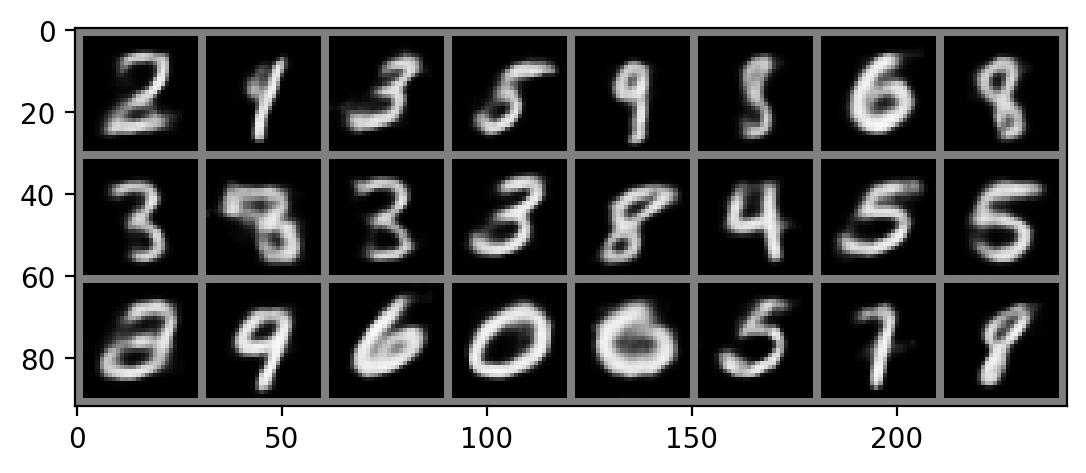

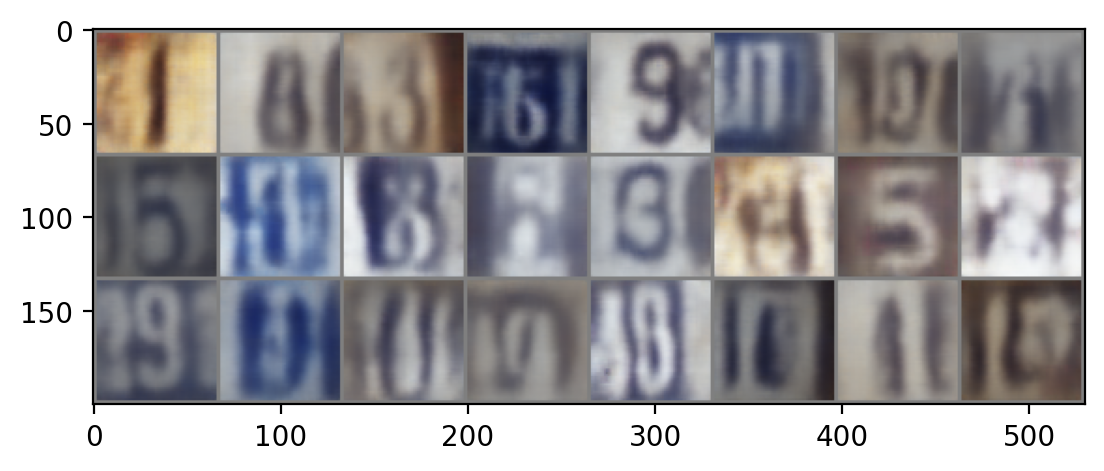

In [ ]:
x_mnist, x_svhm = multiView_vae.sample(24)

imshow(torchvision.utils.make_grid(x_mnist))
imshow(torchvision.utils.make_grid(x_svhm))

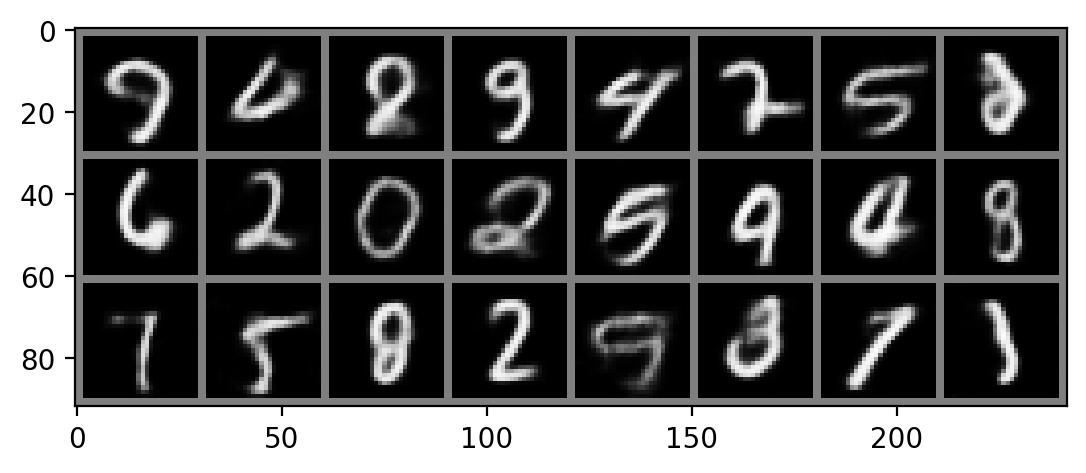

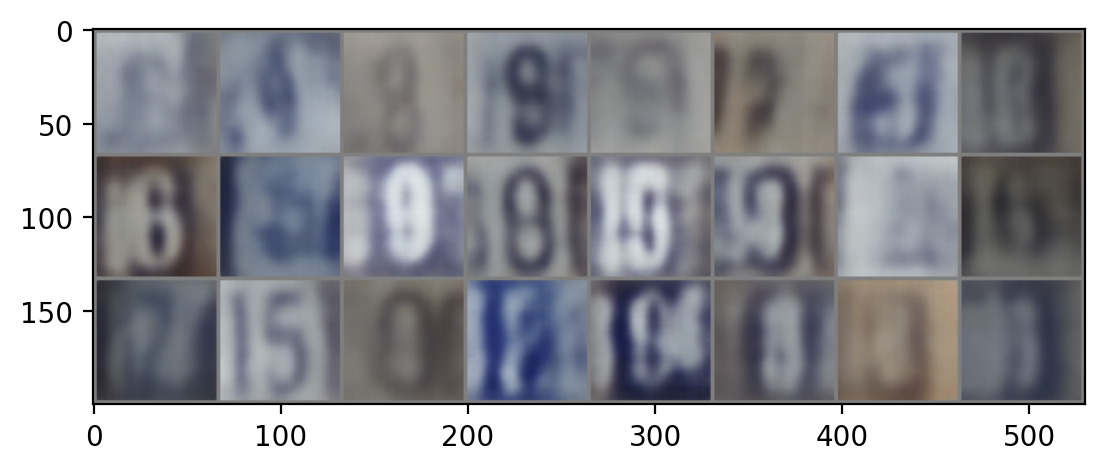

In [ ]:
x_mnist, x_svhm = multiView_vae.sample(24)

imshow(torchvision.utils.make_grid(x_mnist))
imshow(torchvision.utils.make_grid(x_svhm))

### Image Reconstruction

ORIGINAL IMAGES:


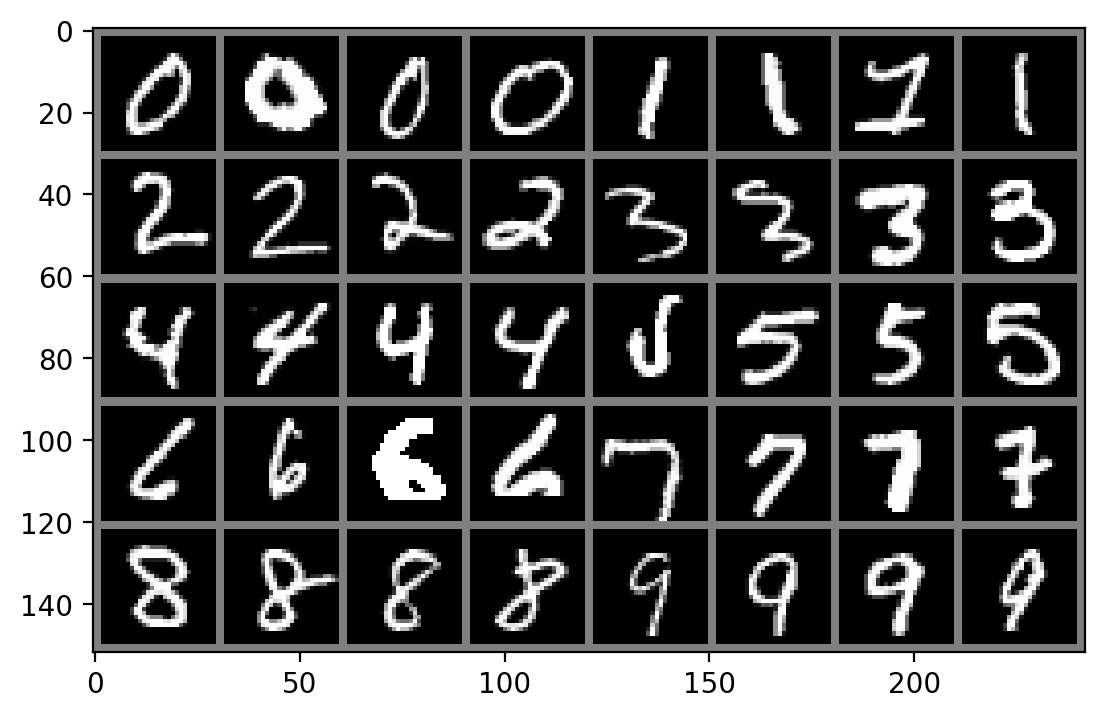

MNIST RECONSTRUCTION:


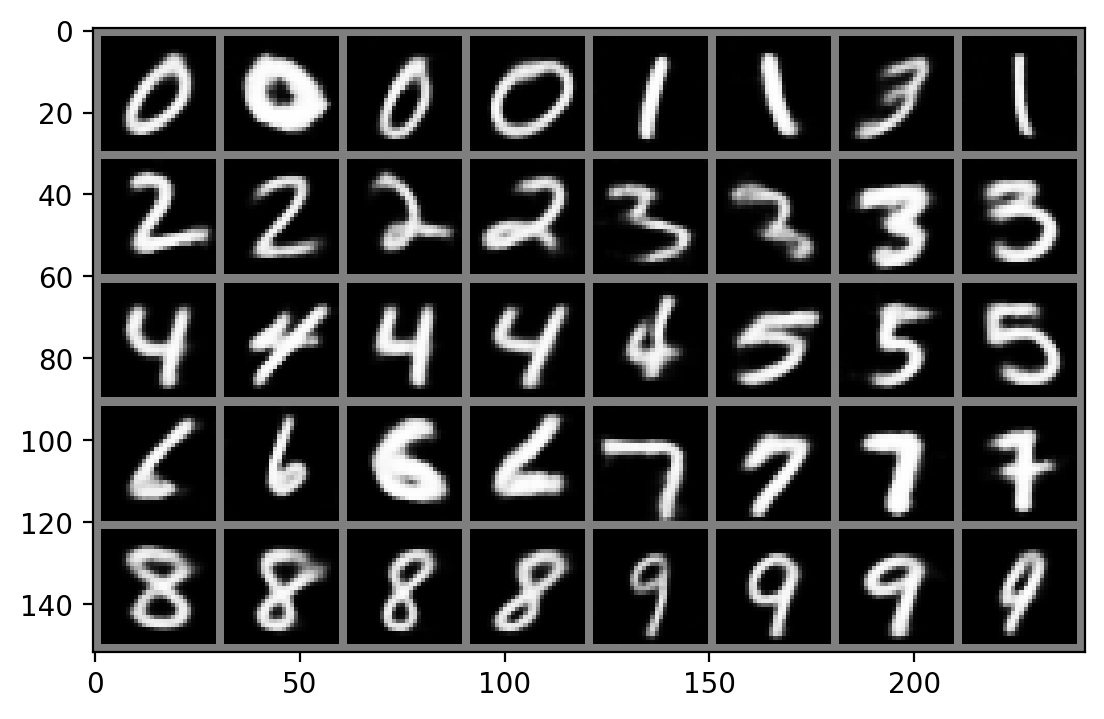

SVHM RECONSTRUCTION:


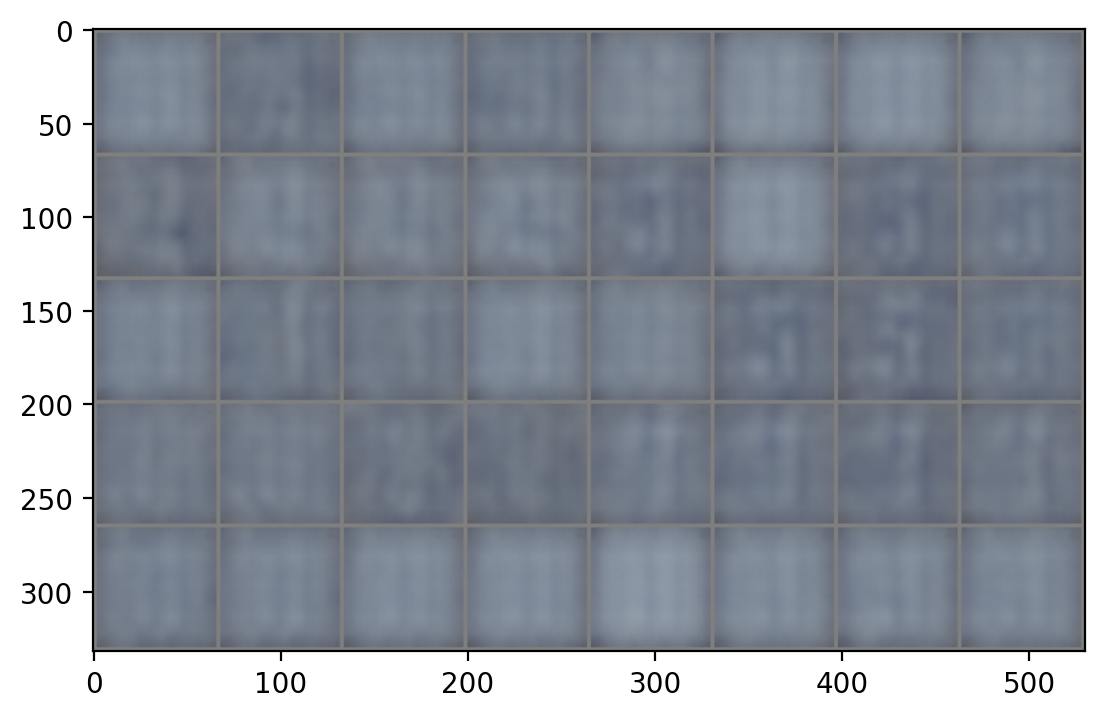

In [ ]:
mnist_train = iter(mnist_reconstruct_trainloader)

i,l = next(mnist_train)

mnist_i, svhm_i = multiView_vae.reconstruct_from_images(i,batch_dataset = 'MNIST')

print('ORIGINAL IMAGES:')

imshow(torchvision.utils.make_grid(i))

print('MNIST RECONSTRUCTION:')

imshow(torchvision.utils.make_grid(mnist_i))

print('SVHM RECONSTRUCTION:')

imshow(torchvision.utils.make_grid(svhm_i))

ORIGINAL IMAGES:


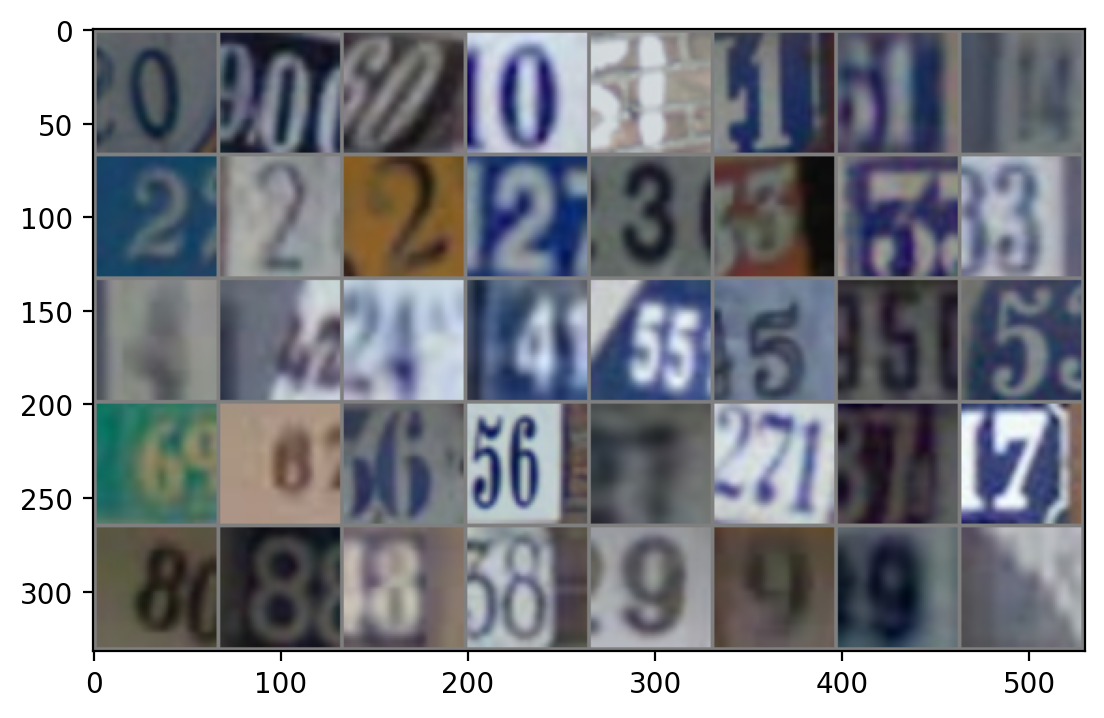

SVHM RECONSTRUCTION:


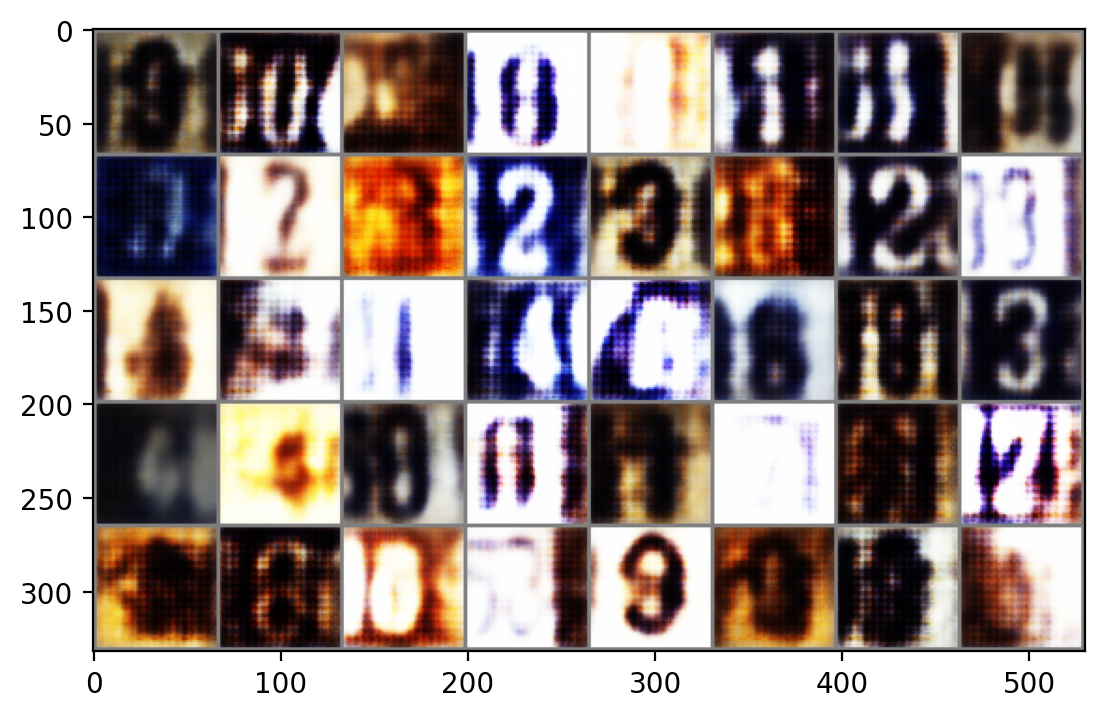

MNIST RECONSTRUCTION:


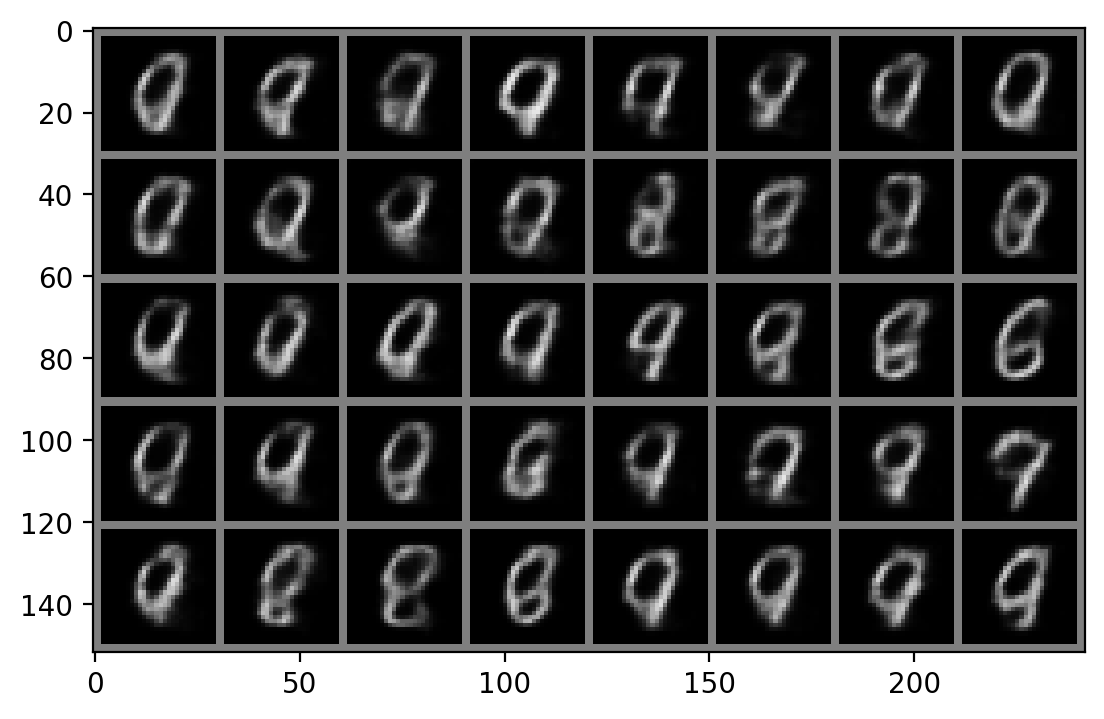

In [ ]:
svhm_train = iter(svhm_reconstruct_trainloader)

i,l = next(svhm_train)

mnist_i, svhm_i = multiView_vae.reconstruct_from_images(i,batch_dataset = 'SVHM')

print('ORIGINAL IMAGES:')

imshow(torchvision.utils.make_grid(i))

print('SVHM RECONSTRUCTION:')

imshow(torchvision.utils.make_grid(svhm_i))

print('MNIST RECONSTRUCTION:')

imshow(torchvision.utils.make_grid(mnist_i))
